<a href="https://colab.research.google.com/github/saritholl/BigDataProject/blob/main/BigDataProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of Gender Differences in Images Across Topics and Time in Scientific Articles

Sarit Hollander: 206172686
Leah Wachtfogel: 206098931

# Extracting the data

We employed web scraping to extract figures from scientific papers published in IEEE journals. Our selection encompassed seven specific topics: Natural Language Processing (NLP), Recommendations, Vision, Cybersecurity, Fraud, Biology and Psychology. For each of these topics, we retrieved a maximum of 60 papers per year, starting from 2010 until the present date.

The obtained results, containing the links to the figures, publication year, authors, authors_info (gender) and respective topics, were saved to a CSV file.

We extracted the gender using the bio information under the author name by regular expression pattern to match gender-related words such as he/she/his/her/hers. To some of the authors there was no bio information so we used the gender guesser on the first author with it's first name. Since some names are non-english names, there are still first authors with 'unknown' gender in the dataset.

To address this issue, we extracted the names of authors whose genders were still unknown. We then provided this list to ChatGPT and asked it to return a gender for each name.

Unfortunately, some names remain unknown, especially those written as single characters or abbreviations like J., S., M, etc. For now, we have dropped these names from the dataset.

Below is the code utilized to carry out the data extraction process:

In [ ]:
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
import re

####### scraping ###########


def extract_gender_related_words(text):
    # Define the regular expression pattern to match gender-related words
    gender_pattern = r'\b(?:he|she|his|her|hers)\b'

    # Find all occurrences of gender-related words in the text
    gender_words = re.findall(gender_pattern, text, flags=re.IGNORECASE)

    return gender_words

def decide_gender_from_words(gender_words):
    gender_words = [x.lower() for x in gender_words]
    he_count = gender_words.count('he')
    his_count = gender_words.count('his')
    she_count = gender_words.count('she')
    her_count = gender_words.count('her')
    hers_count = gender_words.count('hers')

    she_count += her_count
    she_count += hers_count

    he_count += his_count

    if he_count > she_count:
        return 'male'
    elif she_count > he_count:
        return 'female'
    else:
        return 'unknown'

result_dict = {'year': [], 'paper_id': [], 'authors': [], 'figure_name': [], 'figure_link': [], 'topic': []}
topics = ['vision', 'nlp', 'recommendation', 'cyber', 'fraud', 'biology', 'psychology']
firefox_driver = webdriver.Firefox()
rows_per_page = 60
min_year = 2010
max_year = 2024

accepted_cookies = False

for topic in topics:
    print("topic ", topic)
    for year in range(min_year, max_year):
        print("year", year)
        url = 'https://ieeexplore.ieee.org/search/searchresult.jsp?queryText=' + topic + '&highlight=true&returnType=SEARCH&matchPubs=true&rowsPerPage=' + str(
            rows_per_page) + '&ranges=' + str(year) + '_' + str(year) + '_Year&returnFacets=ALL&openAccess=true'

        print(url)
        firefox_driver.get(url)

        if not accepted_cookies:
            firefox_driver.implicitly_wait(15)
            firefox_driver.find_element(by=By.CLASS_NAME, value='cc-btn').click()
            accepted_cookies = True

        all_papers_in_page = firefox_driver.find_elements(by=By.CLASS_NAME, value='fw-bold')

        non_clickable_figures = []

        for i in range(len(all_papers_in_page)):
            p = all_papers_in_page[i]
            doc_url = p.get_attribute('href')
            paper_id = doc_url.split('/')[4]
            firefox_driver.get(doc_url + 'authors#authors')
            authors = [author.text for author in firefox_driver.find_elements(by=By.CLASS_NAME, value='authors-info')]

            authors_info = [info.get_attribute("textContent") for info in firefox_driver.find_elements(by=By.CLASS_NAME, value='mobile-authors-container')]

            genders = []
            for author_info in authors_info:
                gender = decide_gender_from_words(extract_gender_related_words(author_info))
                genders.append(gender)

            firefox_driver.get(doc_url + 'figures#figures')

            figures = firefox_driver.find_elements(by=By.CLASS_NAME, value='figure-full')
            print("found " + str(len(figures)) + ' figures')
            relevant_figs = [fig for fig in figures if fig.tag_name == "img"]
            for fig in relevant_figs:
                fig_link = fig.get_attribute("src")
                fig_name = fig.get_attribute('alt')
                result_dict['paper_id'].append(paper_id)
                result_dict['figure_link'].append(fig_link)
                result_dict['figure_name'].append(fig_name)
                result_dict['year'].append(year)
                result_dict['authors'].append(authors)
                result_dict['authors_info'].append(authors_info)
                result_dict['topic'].append(topic)

            firefox_driver.get(url)

            all_papers_in_page = firefox_driver.find_elements(by=By.CLASS_NAME, value='fw-bold')
            print("finished ", str(i + 1), "/", str(len(all_papers_in_page)))

results_df = pd.DataFrame.from_dict(result_dict)
results_df.to_csv('figures_dataset.csv')

firefox_driver.quit()


Using the gender-guesser to the remain 'unknown' names

In [ ]:
!pip install gender-guesser

In [ ]:
import gender_guesser.detector as gender
import pandas as pd

d = gender.Detector(case_sensitive=False)

file = 'figures_dataset.csv'

df = pd.read_csv(file, index_col=None, encoding='unicode_escape')

def guess_gender_from_name(name):
    gender = d.get_gender(name.split()[0])

    if gender == 'unknown':
        return 'unknown'
    elif gender in ['female', 'mostly_female']:
        return 'female'
    elif gender in ['male', 'mostly_male']:
        return 'male'
    elif gender == 'andy':  # if equally can be male and female
        return 'unknown'

def process_authors_info(authors_info, authors_list):
    authors_info = eval(authors_info)
    authors_list = eval(authors_list)
    if authors_info[0].lower() == 'unknown' and len(authors_list) > 0:
        first_author_name = authors_list[0].split(';')[0].strip()
        gender = guess_gender_from_name(first_author_name)
        authors_info[0] = gender
        return authors_info
    else:
        return authors_info


df['authors_info'] = df.apply(lambda row: process_authors_info(row['authors_info'], row['authors']), axis=1)

df.to_csv('figures_full_dataset.csv', index=False)

Extracting the list of names with unknown gender for chatGPT

In [ ]:
df = pd.read_csv('figures_full_dataset.csv', index_col=None, encoding='unicode_escape')

authors_names = []
def extract_author_first_name(authors_info, authors_list):
    authors_info = eval(authors_info)
    authors_list = eval(authors_list)
    if authors_info[0].lower() == 'unknown' and len(authors_list) > 0:
        first_author_first_name = authors_list[0].split(';')[0].strip().split()[0]
        return first_author_first_name

authors_names_ser = df.apply(lambda row: extract_author_first_name(row['authors_info'], row['authors']), axis=1)
unique_names = set(authors_names_ser.dropna().tolist())

Enter the gender matched to the authors in the dataframe

In [ ]:
def enter_first_author_gender(authors_info, authors_list,names, genders):
    authors_info = eval(authors_info)
    authors_list = eval(authors_list)
    if authors_info[0].lower() == 'unknown' and len(authors_list) > 0:
        first_author_first_name = authors_list[0].split(';')[0].strip().split()[0]
        for i, name in enumerate(names):
            if name == first_author_first_name:
                authors_info[0] = gender[i].lower()
                return authors_info
    else:
        return authors_info

df = pd.read_csv('figures_full_dataset.csv', index_col=None, encoding='unicode_escape')

names = ['Meng-Fen', 'Dilbag', 'S.', 'Xiang', 'Prinkle', 'Tiantong', 'Jiajia', 'Yao', 'Wenqiang', 'Yu', 'Elahe', 'Cristianne', 'Kuo', 'Xianghua', 'Guoling', 'Zhaobin', 'Yu-Ting', 'Jiafei', 'Jianping', 'Zhenchao', 'Zhuo', 'Amirreza', 'Qi', 'Po-Han', 'Kunqian', 'Busra', 'Bjoern', 'Xi', 'M.', 'Subhrajit', 'Zixuan', 'C.', 'Jinghuai', 'Xinglie', 'Zhengfa', 'Jérôme', 'Minhan', 'Wenbin', 'Dung', 'Yin-Ting', 'Zheping', 'J.', 'Linyu', 'Zhi-Hui', 'Ji', 'Maliheh', 'Chiao', 'Chun-Ren', 'Jian', 'Anastacia', 'Wei', 'Adwait', 'Wenxiang', 'N.', 'Nazreen', 'Xiaofei', 'Jianglei', 'Shiyu', 'Annan', 'Jörg', 'Beom-Chan', 'Zhenyu', 'Lin-Hung', 'Yueying', 'Pieter-Jan', 'Jiacheng', 'Bo-Wen', 'Preksha', 'Shipeng', 'Yingkui', 'Y.', 'Manohar', 'Jiong', 'Meng', 'Jing', 'Nithin', 'Ruoyu', 'A.', 'Hemal', 'Longxi', 'Yanli', 'Te-Cheng', 'Chuting', 'Meiyan', 'Pratyush', 'Shih-Ching', 'Lu', 'Furui', 'Li-Li', 'Ling', 'E.', 'Peiyin', 'Chungmin', 'Gagan', 'Yan-Jia', 'Amol', 'Minchao', 'Abhijeet', 'Houchi', 'Haseong', 'Mayur', 'Hui', 'Yuqi', 'Changyin', 'Anup', 'Mei', 'R.', 'Lizhen', 'Bin', 'Laszlo', 'Bochao', 'Hang', 'Soo-Yeon', 'Fábio', 'Aditeya', 'Pengyao', 'Zhang', 'B.', 'Yike', 'Shivanthan', 'Hua', 'Li', 'Yi-Ling', 'Ayush', 'Vionarica', 'Yuhui', 'Arbab', 'Anish', 'María', 'Zhi', 'Wujiao', 'Jaydeep', 'Zhongliang', 'Rong', 'Luoluo', 'Arjav', 'Penglei', 'Turki', 'Xiaoyu', 'Jingjing', 'Zhen', 'Wenzheng', 'Yitian', 'T.', 'Jiaen', 'Abhishek', 'Fenfang', 'Shurun', 'Zhiqian', 'Minsi', 'Hansong', 'Taewoo', 'Hongbo', 'Ryo', 'Shrinivas', 'Yue', 'Li-Wei', 'Yin', 'Emil?', 'Po-Yen', 'Chunsheng', 'Nantheera', 'Sixian', 'Kaiyin', 'Basabdatta', 'Benliu', 'Xinyu', 'Zenghui', 'G.', 'Poorya', 'Hyein', 'Lei', 'Kimberley-Dale', 'Shang']
gender = ['female', 'male', 'unknown', 'male', 'Female', 'Male', 'Female', 'Male', 'Male', 'Male', 'Female', 'Female', 'Male', 'Female', 'Male', 'Male', 'Female', 'female',
 'Male','Male', 'Male', 'Male', 'female', 'Male', 'Male', 'Female', 'Male', 'unknown','unknown', 'Male', 'Male', 'unknown','Male', 'Male', 'Male', 'Male', 'Male', 'Male',
 'Male','Female', 'Male', 'unknown', 'Female', 'male', 'male','Female', 'Female', 'Male', 'Male', 'Female','unknown', 'Male', 'Male', 'unknown', 'Female', 'Male', 'Male','female',
 'Female','Male','Male','Male','Male','Female','Male','Male','Male','Female','Male','Male','male','Male','Male','Male','male','Male','female','male','Male','Male','Female','Male','Female',
 'Female','Male','Female','male','Male','Female','female','female','Female','Male','Male','Female','Male','Male','Male','Male','Male','Male','female','male','Male','Male','Female','male',
 'Female','Male','Male','Male','Male','Female','Male','Male','Male','Male','male','Male','Male','female','male','Female','Male','Female','female','Male','Male','Female','male','Female','Male','Male',
 'Female','Female','Male','Male','Male','male','Female','Male','Male','Male','unknown','Female','Male','Female','Female','Male','Female','Male','Male','Male','Male','Male','female','Male','female',
 'Male','Male','Male','Female','Female','Male','Female','Male','female','Male','unknown','Male','Female','Male','Female','male']

df['authors_info'] = df.apply(lambda row: enter_first_author_gender(row['authors_info'], row['authors'],names, gender), axis=1)
df.to_csv('figures_full_dataset_updated.csv', index=False)

Drop papers wich the first author's gender is 'unknown'

In [ ]:
df = pd.read_csv('figures_full_dataset_updated.csv', index_col=None, encoding='unicode_escape')

df_filter = df[~df['authors_info'].apply(lambda x: eval(x)[0] == 'unknown')]
df_filter.to_csv('my_figures_dataset.csv', index=False)

# Imports

In [1]:
!pip install catboost
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 1.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.utils import resample
import os
import shap
import ast
import glob
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
from torchvision.models import resnet50
from torchvision.models.vgg import vgg16
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
import ast
import re
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import KDTree
import imageio
import networkx as nx
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve, auc
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Data Preparation

In [44]:
# Load the CSV file into a DataFrame
file_path = 'dataset_6000.csv'
full_df = pd.read_csv(file_path, index_col=None, encoding='unicode_escape')

full_df['authors_info'] = full_df['authors_info'].apply(lambda x: eval(x))
full_df['authors'] = full_df['authors'].apply(lambda x: eval(x))
full_df['authors'] = full_df['authors'].apply(lambda x: [author.replace(';', '') for author in x])

# Add column of the first author of the papaer
full_df['first_author'] = full_df['authors'].apply(lambda x: x[0])

# Add column of the gender of the first author of the papaer
full_df['gender'] = full_df['authors_info'].apply(lambda x: x[0])

# Rearrange columns
full_df = full_df[['year', 'paper_id', 'topic', 'first_author', 'gender','authors','authors_info', 'figure_name', 'figure_link']]

# Create one row for each paper and create list of figures in the figure_link column
my_df = full_df.groupby(['year', 'paper_id', 'topic', 'first_author', 'gender']).agg({'figure_link': lambda x: x.tolist()}).reset_index()

df = my_df
df

,year,paper_id,topic,first_author,gender,figure_link
0,2010,5288522,recommendation,Fabian Abel,male,[https://ieeexplore.ieee.org/mediastore_new/IE...
1,2010,5415547,vision,Alberto Broggi,male,[https://ieeexplore.ieee.org/mediastore_new/IE...
2,2010,10151983,vision,Bing Li,male,[https://ieeexplore.ieee.org/mediastore_new/IE...
3,2010,10167429,vision,Ying Huang,female,[https://ieeexplore.ieee.org/mediastore_new/IE...
4,2011,5539765,psychology,Maria C.R. Harrington,female,[https://ieeexplore.ieee.org/mediastore_new/IE...
...,...,...,...,...,...,...
2306,2023,10177172,fraud,Varun Malik,male,[https://ieeexplore.ieee.org/mediastore_new/IE...
2307,2023,10177698,recommendation,Bing Yan,male,[https://ieeexplore.ieee.org/mediastore_new/IE...
2308,2023,10184000,cyber,Kelvin Anto,male,[https://ieeexplore.ieee.org/mediastore_new/IE...
2309,2023,10184430,psychology,Bingxin Li,female,[https://ieeexplore.ieee.org/mediastore_new/IE...


# Data exploration

## Paper Features Exploration

In [ ]:
# Display the first few rows of the DataFrame
print("First 5 rows of the DataFrame:")
print(df.head())

# Get basic statistics of the numerical columns
print("\nBasic statistics:")
print(df.describe())

# Check the data types of each column
print("\nData types of each column:")
print(df.dtypes)

# Count the number of unique authors
unique_authors = df['first_author'].explode().nunique()
print(f"\nNumber of unique authors: {unique_authors}")

# Check for missing data in the DataFrame
missing_data = df.isnull().sum()

# Display the number of missing values for each column
print("Missing Data:")
print(missing_data)

# Get unique values in the 'topic' column
print("topics:", df['topic'].unique())

# Count the occurrences of each value in the 'gender' column
print("Gender count:", df['gender'].value_counts())

# Number of papers for each gender
papers_by_gender = df.groupby('gender')['paper_id'].count()
print("Number of papers for each gender:", papers_by_gender)

First 5 rows of the DataFrame:
   year  paper_id           topic           first_author  gender  \
0  2010   5288522  recommendation            Fabian Abel    male   
1  2010   5415547          vision         Alberto Broggi    male   
2  2010  10151983          vision                Bing Li    male   
3  2010  10167429          vision             Ying Huang  female   
4  2011   5539765      psychology  Maria C.R. Harrington  female   

                                         figure_link  
0  [https://ieeexplore.ieee.org/mediastore_new/IE...  
1  [https://ieeexplore.ieee.org/mediastore_new/IE...  
2  [https://ieeexplore.ieee.org/mediastore_new/IE...  
3  [https://ieeexplore.ieee.org/mediastore_new/IE...  
4  [https://ieeexplore.ieee.org/mediastore_new/IE...  

Basic statistics:
              year      paper_id
count  2311.000000  2.311000e+03
mean   2019.089572  8.699988e+06
std       2.874011  1.072946e+06
min    2010.000000  5.288522e+06
25%    2017.000000  7.983686e+06
50%    2020.0

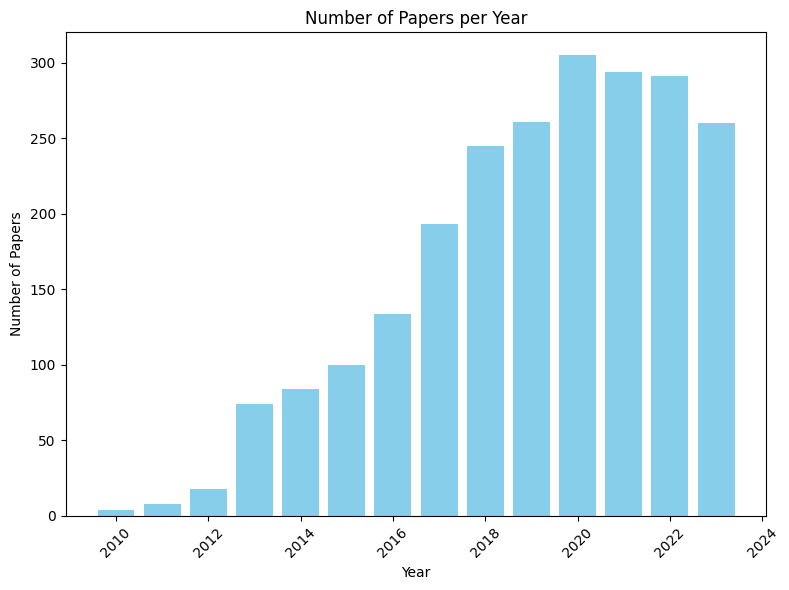

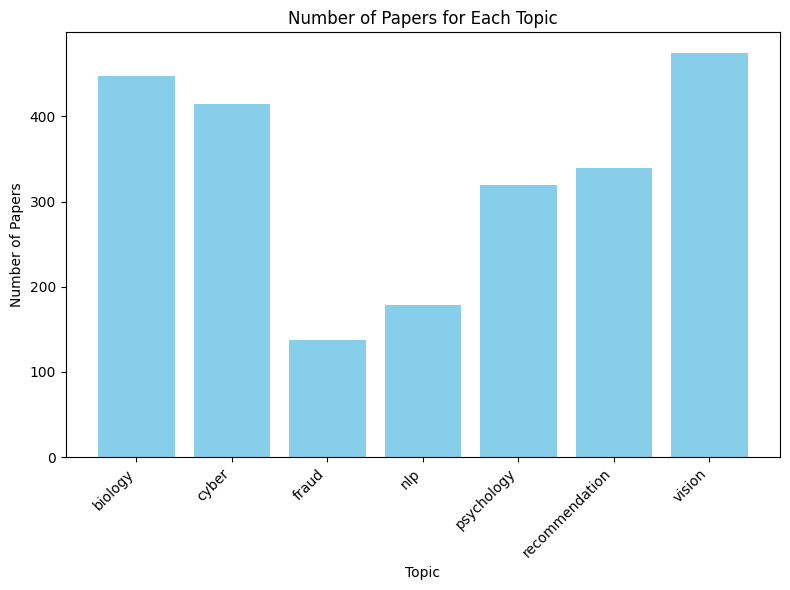

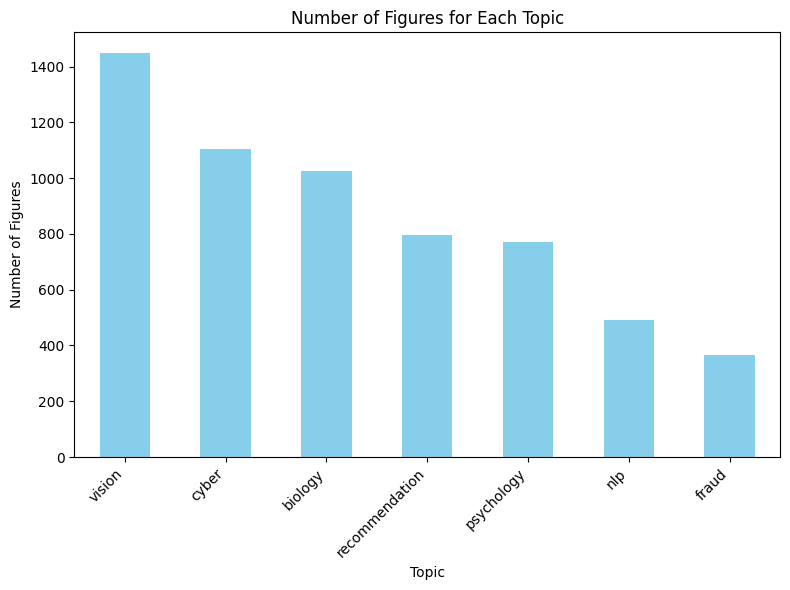

In [ ]:
# Number of Papers per Year
papers_per_year = df.groupby('year')['paper_id'].nunique().reset_index(name='count')

plt.figure(figsize=(8, 6))
plt.bar(papers_per_year['year'], papers_per_year['count'], color='skyblue')
plt.xlabel('Year')
plt.ylabel('Number of Papers')
plt.title('Number of Papers per Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Number of Papers per Topic
papers_per_topic = df.groupby('topic')['paper_id'].nunique().reset_index(name='count')

plt.figure(figsize=(8, 6))
plt.bar(papers_per_topic['topic'], papers_per_topic['count'], color='skyblue')
plt.xlabel('Topic')
plt.ylabel('Number of Papers')
plt.title('Number of Papers for Each Topic')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Number of figures for each topic
# Explode the 'figure_link' column to create separate rows for each link
exploded_df = df.explode('figure_link')

# Count the number of figures for each topic
figure_counts = exploded_df['topic'].value_counts()

# Plot the number of figures for each topic
plt.figure(figsize=(8, 6))
figure_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Topic')
plt.ylabel('Number of Figures')
plt.title('Number of Figures for Each Topic')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

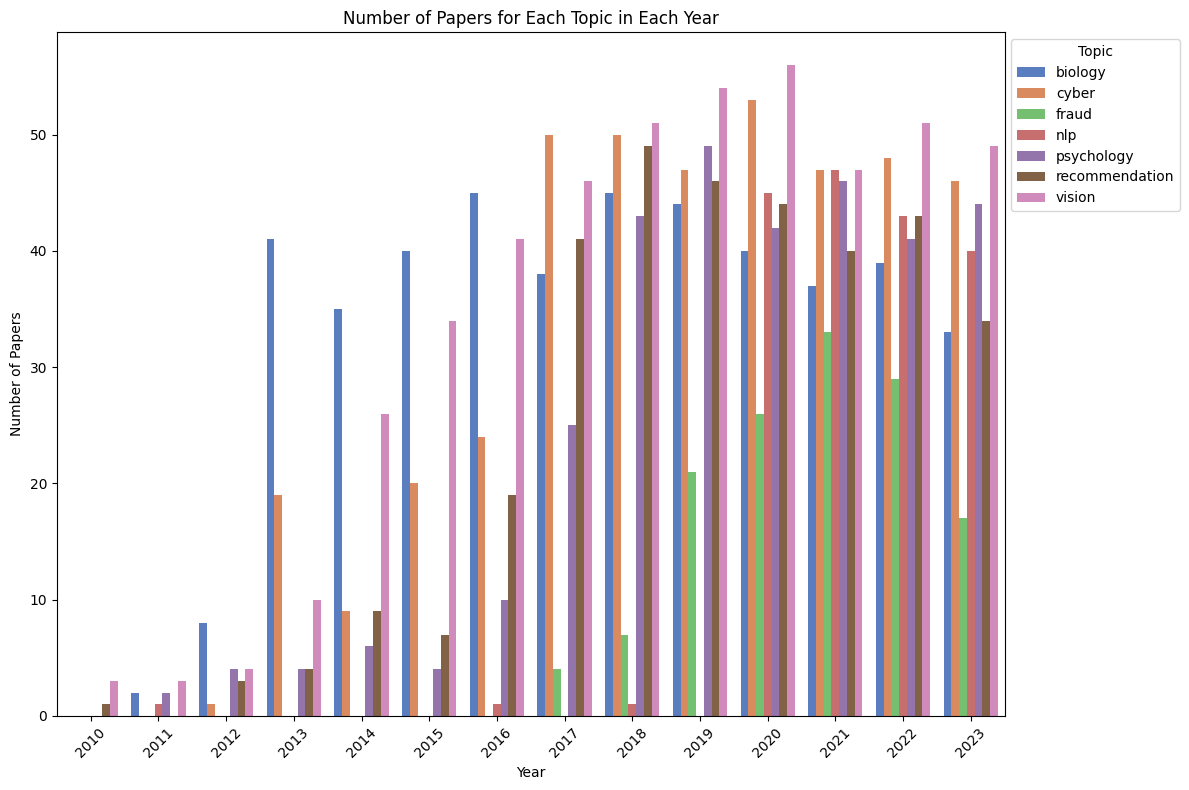

In [ ]:
# Number of papers for each topic in each year
papers_per_topic_per_year = df.groupby(['topic', 'year'])['paper_id'].nunique().reset_index(name='count')
pivot_table = papers_per_topic_per_year.pivot_table(index='year', columns='topic', values='count', fill_value=0)
melted_data = pivot_table.reset_index().melt(id_vars='year', var_name='topic', value_name='count')

plt.figure(figsize=(12, 8))
sns.barplot(data=melted_data, x='year', y='count', hue='topic', palette='muted')
plt.xlabel('Year')
plt.ylabel('Number of Papers')
plt.title('Number of Papers for Each Topic in Each Year')
plt.xticks(rotation=45)
plt.legend(title='Topic', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

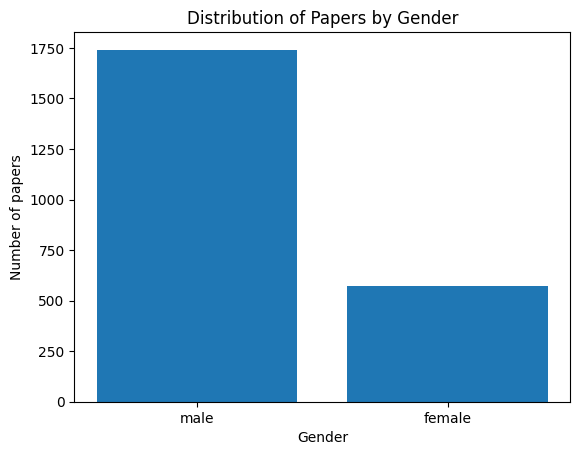

male      1741
female     570
Name: gender, dtype: int64


In [132]:
# Count the occurrences of each gender
gender_counts = df['gender'].value_counts()

# Plot the gender distribution as a bar plot
plt.bar(gender_counts.index, gender_counts.values)
plt.xlabel('Gender')
plt.ylabel('Number of papers')
plt.title('Distribution of Papers by Gender')
plt.show()

print(gender_counts)

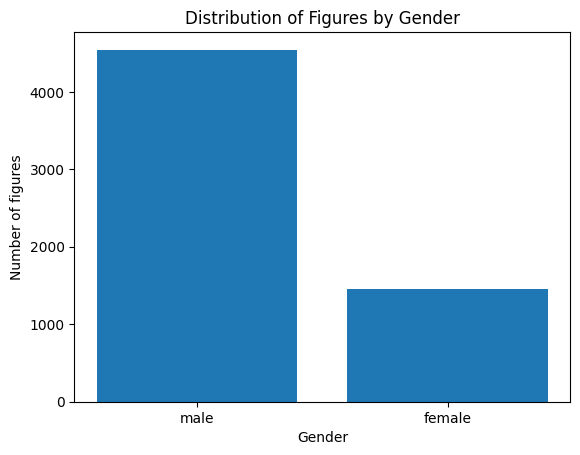

male      4543
female    1457
Name: gender, dtype: int64


In [133]:
# Count the occurrences of each gender
full_gender_counts = full_df['gender'].value_counts()

# Plot the gender distribution as a bar plot
plt.bar(full_gender_counts.index, full_gender_counts.values)
plt.xlabel('Gender')
plt.ylabel('Number of figures')
plt.title('Distribution of Figures by Gender')
plt.show()

print(full_gender_counts)

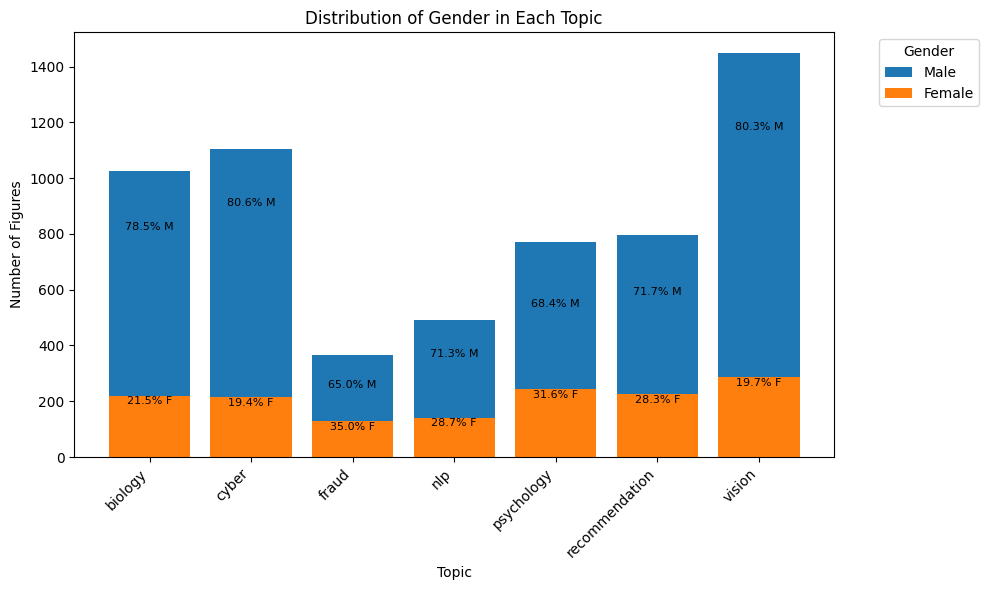

In [66]:
exploded_df = df.explode('figure_link')
gender_counts_by_topic = exploded_df.groupby(['topic', 'gender']).size().unstack(fill_value=0)

# Calculate the total count of figures for each topic
topic_total_counts = gender_counts_by_topic.sum(axis=1)

# Calculate the percentage of female and male figures in each topic
gender_percentages = gender_counts_by_topic.div(topic_total_counts, axis=0) * 100

fig, ax = plt.subplots(figsize=(10, 6))
for i, (male_count, female_count) in enumerate(zip(gender_counts_by_topic['male'], gender_counts_by_topic['female'])):
    male_percentage = (male_count / (male_count + female_count)) * 100
    plt.bar(i, male_count, bottom=female_count, color='#1f77b4', label='Male')
    plt.bar(i, female_count, color='#ff7f0e', label='Female')
    plt.annotate(f'{male_percentage:.1f}% M', (i, male_count + 10), ha='center', color='black', fontsize=8)
    plt.annotate(f'{100 - male_percentage:.1f}% F', (i, female_count - 30), ha='center', color='black', fontsize=8)

plt.xlabel('Topic')
plt.ylabel('Number of Figures')
plt.title('Distribution of Gender in Each Topic')
plt.legend(title='Gender', loc='upper left', labels=['Male', 'Female'], bbox_to_anchor=(1.05, 1))
plt.xticks(range(len(gender_counts_by_topic)), gender_counts_by_topic.index, rotation=45, ha='right')
plt.tight_layout()
plt.show()

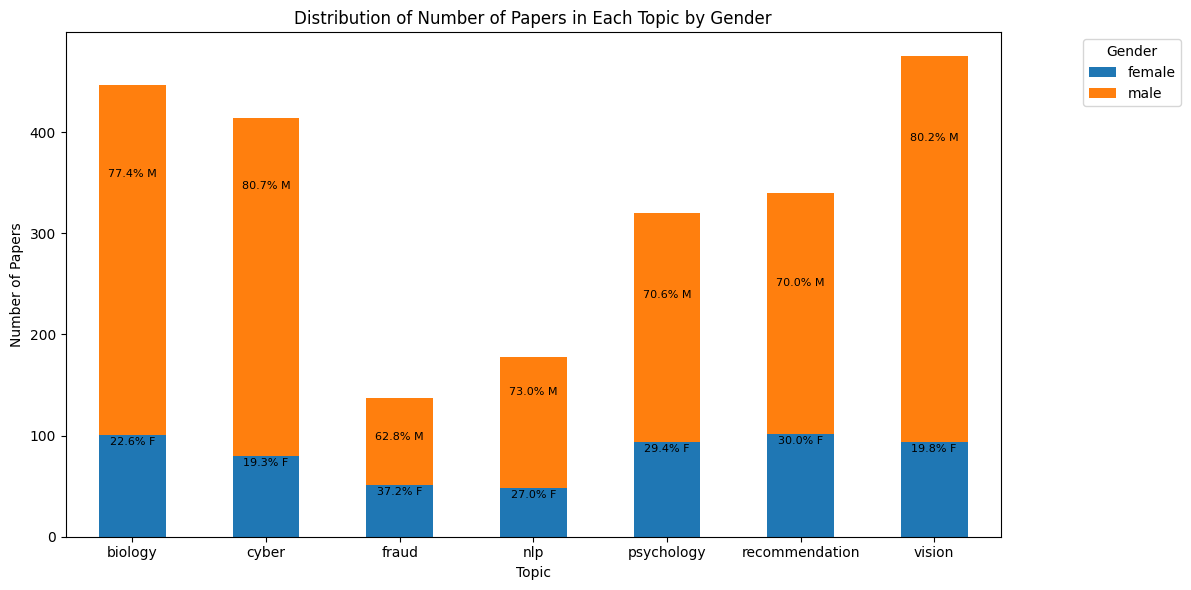

In [88]:
# Group by 'topic' and 'gender' and count the number of unique papers for each combination
gender_counts_by_topic = df.drop_duplicates(['paper_id', 'topic', 'gender']).groupby(['topic', 'gender']).size().reset_index(name='num_papers')

# Pivot the table to have 'gender' as columns and 'num_papers' as values
gender_counts_pivot = gender_counts_by_topic.pivot(index='topic', columns='gender', values='num_papers').fillna(0)

# Calculate total papers for each topic
gender_counts_pivot['total_papers'] = gender_counts_pivot['female'] + gender_counts_pivot['male']

# Calculate male and female percentages
gender_counts_pivot['male_percentage'] = (gender_counts_pivot['male'] / gender_counts_pivot['total_papers']) * 100
gender_counts_pivot['female_percentage'] = (gender_counts_pivot['female'] / gender_counts_pivot['total_papers']) * 100

# Plot the grouped bar plot
fig, ax = plt.subplots(figsize=(12, 6))
gender_counts_pivot[['female', 'male']].plot(kind='bar', stacked=True, ax=ax)
for i, (male_count, female_count) in enumerate(zip(gender_counts_pivot['male'], gender_counts_pivot['female'])):
    male_percentage = (male_count / (male_count + female_count)) * 100
    plt.annotate(f'{male_percentage:.1f}% M', (i, male_count + 10), ha='center', color='black', fontsize=8)
    plt.annotate(f'{100 - male_percentage:.1f}% F', (i, female_count - 10), ha='center', color='black', fontsize=8)

plt.xlabel('Topic')
plt.ylabel('Number of Papers')
plt.title('Distribution of Number of Papers in Each Topic by Gender')
plt.legend(title='Gender', loc='upper right', labels=gender_counts_pivot[['female', 'male']].columns, bbox_to_anchor=(1.13, 1))
plt.xticks(range(len(gender_counts_pivot)), gender_counts_pivot.index, rotation=0)
plt.tight_layout()
plt.show()

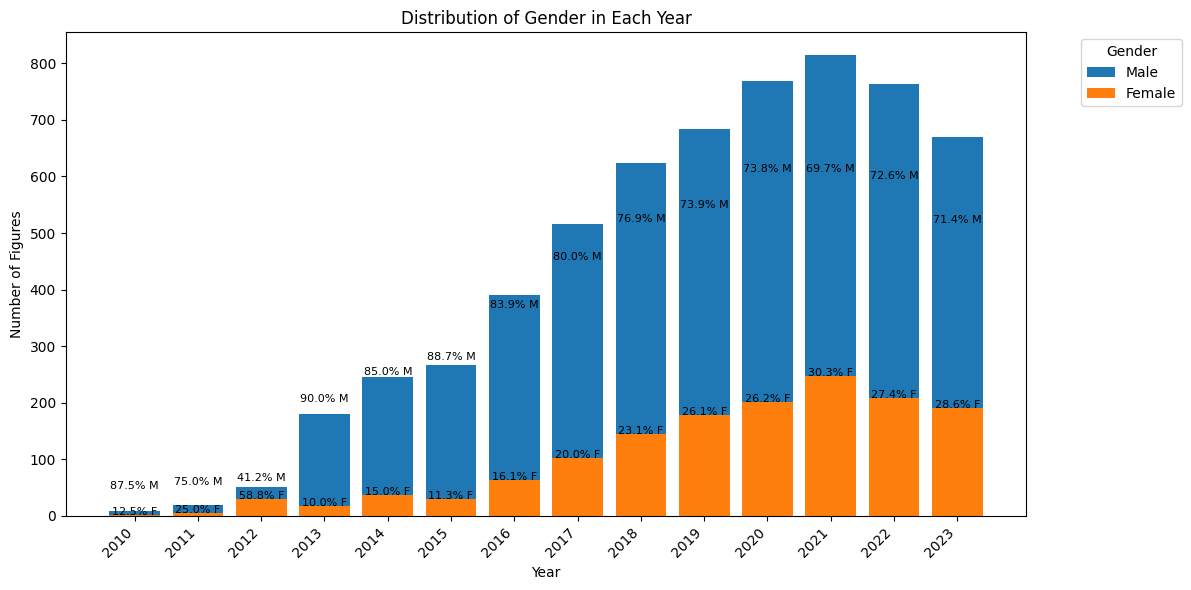

In [72]:
exploded_df = df.explode('figure_link')
gender_counts_by_topic = exploded_df.groupby(['year', 'gender']).size().unstack(fill_value=0)

# Calculate the total count of figures for each topic
topic_total_counts = gender_counts_by_topic.sum(axis=1)

# Calculate the percentage of female and male figures in each topic
gender_percentages = gender_counts_by_topic.div(topic_total_counts, axis=0) * 100

fig, ax = plt.subplots(figsize=(12, 6))
for i, (male_count, female_count) in enumerate(zip(gender_counts_by_topic['male'], gender_counts_by_topic['female'])):
    male_percentage = (male_count / (male_count + female_count)) * 100
    plt.bar(i, male_count, bottom=female_count, color='#1f77b4', label='Male')
    plt.bar(i, female_count, color='#ff7f0e', label='Female')
    plt.annotate(f'{male_percentage:.1f}% M', (i, male_count + 40), ha='center', color='black', fontsize=8)
    plt.annotate(f'{100 - male_percentage:.1f}% F', (i, female_count), ha='center', color='black', fontsize=8)

plt.xlabel('Year')
plt.ylabel('Number of Figures')
plt.title('Distribution of Gender in Each Year')
plt.legend(title='Gender', loc='upper left', labels=['Male', 'Female'], bbox_to_anchor=(1.05, 1))
plt.xticks(range(len(gender_counts_by_topic)), gender_counts_by_topic.index, rotation=45, ha='right')
plt.tight_layout()
plt.show()

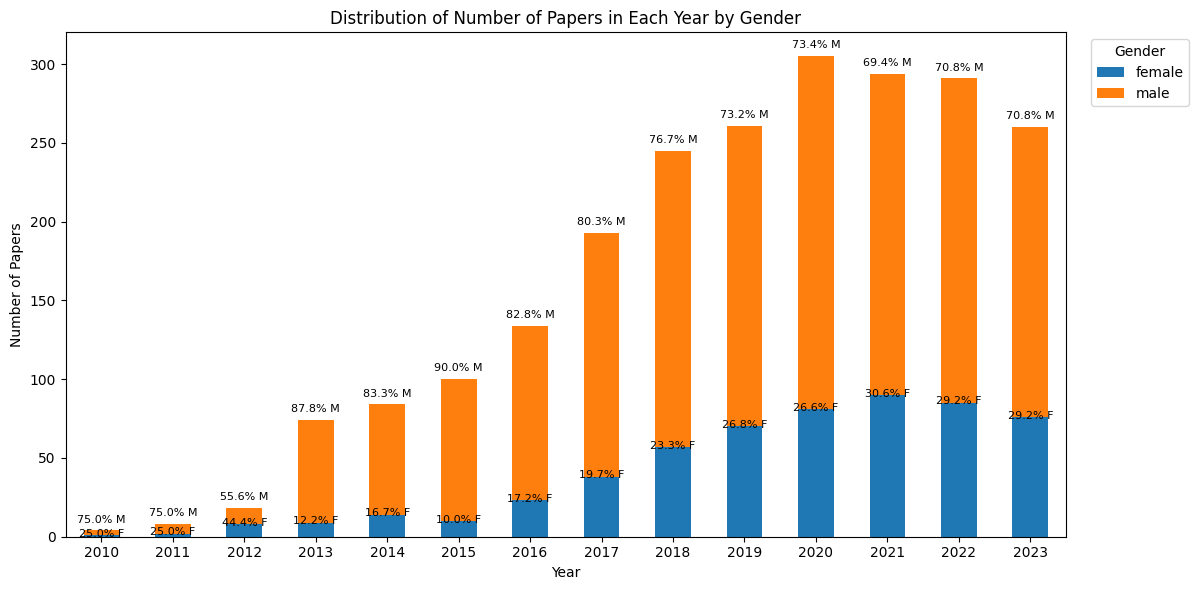

In [105]:
# Group by 'year' and 'gender' and count the number of unique papers for each combination
gender_counts_by_topic = df.drop_duplicates(['paper_id', 'year', 'gender']).groupby(['year', 'gender']).size().reset_index(name='num_papers')

# Pivot the table to have 'gender' as columns and 'num_papers' as values
gender_counts_pivot = gender_counts_by_topic.pivot(index='year', columns='gender', values='num_papers').fillna(0)

# Calculate total papers for each year
gender_counts_pivot['total_papers'] = gender_counts_pivot['female'] + gender_counts_pivot['male']

# Calculate male and female percentages
gender_counts_pivot['male_percentage'] = (gender_counts_pivot['male'] / gender_counts_pivot['total_papers']) * 100
gender_counts_pivot['female_percentage'] = (gender_counts_pivot['female'] / gender_counts_pivot['total_papers']) * 100

# Plot the grouped bar plot
fig, ax = plt.subplots(figsize=(12, 6))
gender_counts_pivot[['female', 'male']].plot(kind='bar', stacked=True, ax=ax)

for i, (male_count, female_count) in enumerate(zip(gender_counts_pivot['male'], gender_counts_pivot['female'])):
    female_percentage = (female_count / (male_count + female_count)) * 100
    plt.annotate(f'{female_percentage:.1f}% F', (i, female_count - 1), ha='center', color='black', fontsize=8)
    plt.annotate(f'{100 - female_percentage:.1f}% M', (i, male_count + female_count + 5), ha='center', color='black', fontsize=8)

plt.xlabel('Year')
plt.ylabel('Number of Papers')
plt.title('Distribution of Number of Papers in Each Year by Gender')
plt.legend(title='Gender', loc='upper right', labels=gender_counts_pivot[['female', 'male']].columns, bbox_to_anchor=(1.13, 1))
plt.xticks(range(len(gender_counts_pivot)), gender_counts_pivot.index, rotation=0)
plt.tight_layout()
plt.show()


## Image Features Exploration

In [ ]:
file_path = '/content/dataset_6000.csv'
full_df = pd.read_csv(file_path, index_col=None, encoding='unicode_escape')

In [ ]:
# feature extraction, color and size

full_df['fig_size'] = full_df['fig_size'].apply(ast.literal_eval)
full_df['width'] = full_df['fig_size'].apply(lambda x: x[1])
full_df['height'] = full_df['fig_size'].apply(lambda x: x[0])

# Function to parse and convert color string to RGB tuple
def parse_color_string(color_string):
    components = [float(value)/255.0 for value in color_string.strip('[]').split()]
    if len(components) == 1:
        # Grayscale color
        return (components[0], components[0], components[0])
    else:
        # RGB color
        return tuple(components)

def is_greyscale(color_string):
    components = [float(value)/255.0 for value in color_string.strip('[]').split()]
    if len(components) == 1:
        # Grayscale color
        return True
    else:
        # RGB color
        return False

# Apply the function to create RGB tuples
full_df["color_grey"] = full_df["avg_color"].apply(is_greyscale)
full_df["color_rgb"] = full_df["avg_color"].apply(parse_color_string)
full_df['color_red'] = full_df['color_rgb'].apply(lambda x: x[0])
full_df['color_green'] = full_df['color_rgb'].apply(lambda x: x[1])
full_df['color_blue'] = full_df['color_rgb'].apply(lambda x: x[2])

<Figure size 1000x600 with 0 Axes>

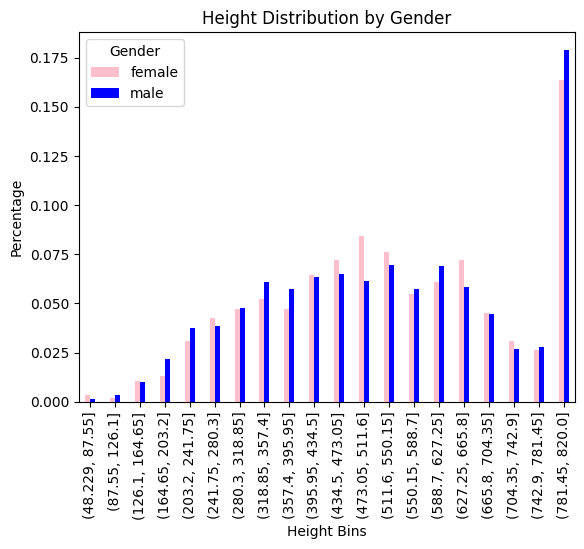

In [ ]:
plt.figure(figsize=(10, 6))

grouped = full_df.groupby(["gender", pd.cut(full_df['height'], bins=20)])['height'].count().unstack('gender')
normalized_data = grouped.div(grouped.sum(axis=0), axis=1)

normalized_data.plot(kind='bar', color=["pink", "blue"], width=0.4)
plt.xlabel("Height Bins")
plt.ylabel("Percentage")
plt.title("Height Distribution by Gender")
plt.legend(title="Gender")
plt.show()

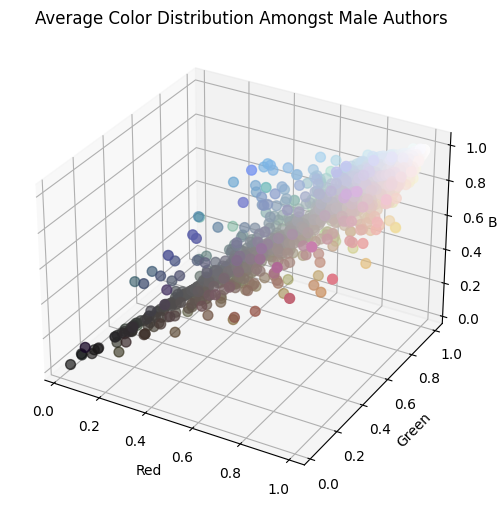

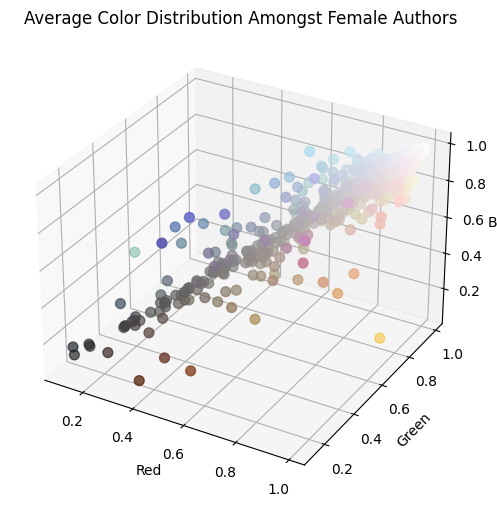

In [ ]:
def plot_colors(df_, gend_name):
  # Set up the figure and axes
  fig = plt.figure(figsize=(8, 6))
  ax = fig.add_subplot(111, projection='3d')

  # Extract RGB components from DataFrame
  r = df_["color_rgb"].apply(lambda x: x[0])
  g = df_["color_rgb"].apply(lambda x: x[1])
  b = df_["color_rgb"].apply(lambda x: x[2])

  # Scatter plot in RGB space
  ax.scatter(r, g, b, c=df_["color_rgb"], s=50, marker='o')

  # Set labels and title
  ax.set_xlabel('Red')
  ax.set_ylabel('Green')
  ax.set_zlabel('Blue')
  ax.set_title(f'Average Color Distribution Amongst {gend_name} Authors')

  plt.show()

plot_colors(full_df[full_df["gender"] == "male"], "Male")
plot_colors(full_df[full_df["gender"] == "female"], "Female")

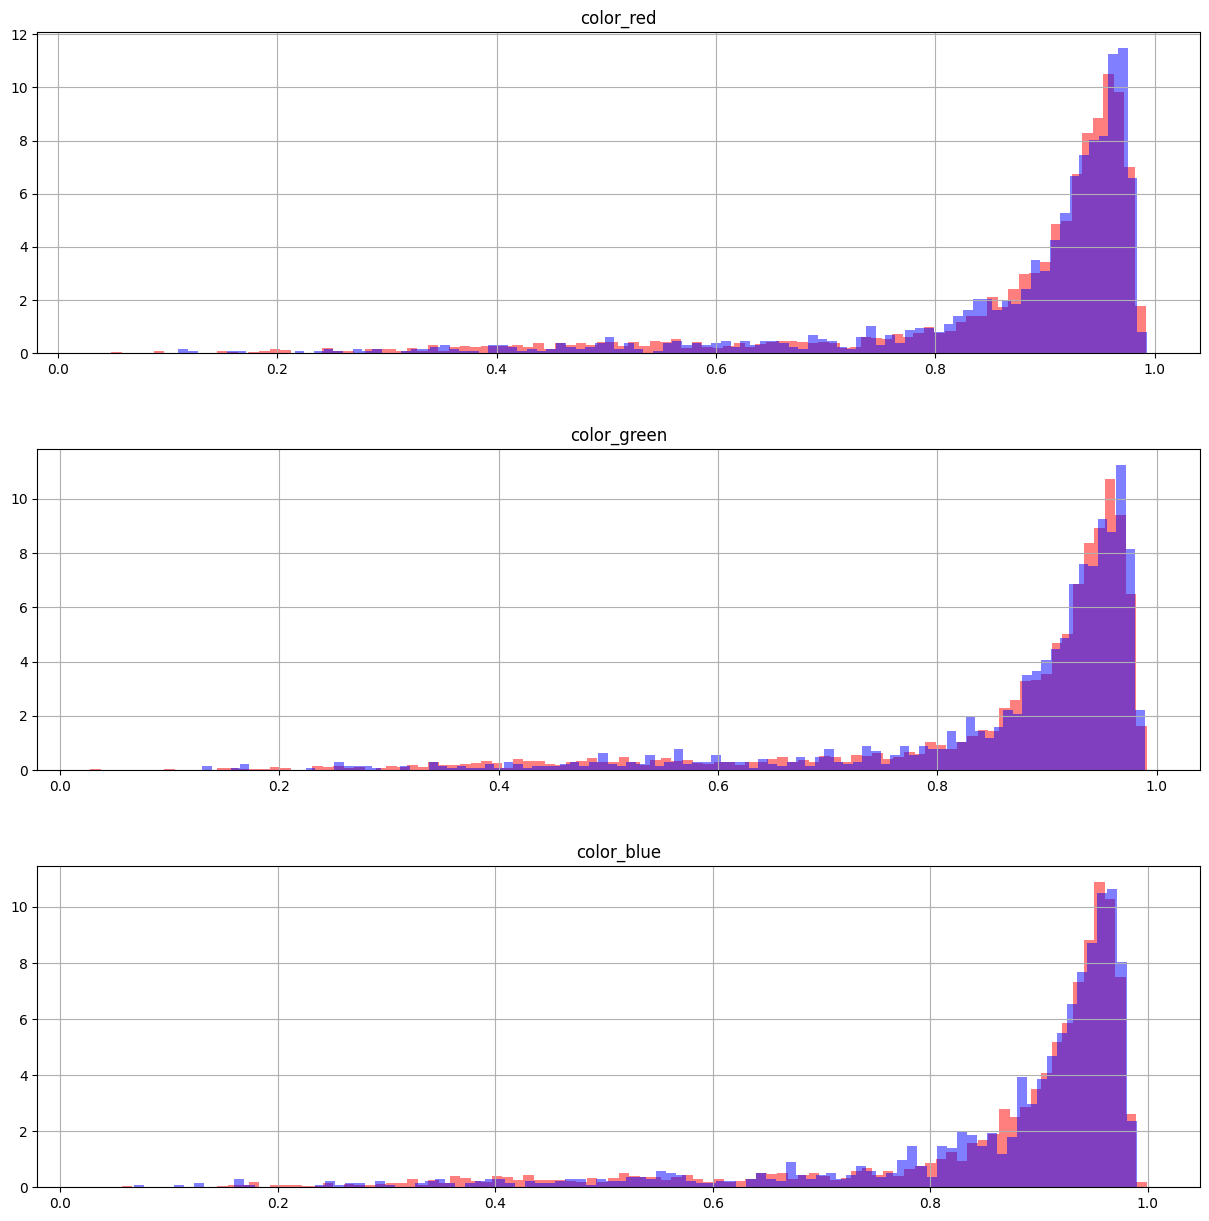

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 15))
df_col = full_df[["gender","color_red","color_green","color_blue"]]
df_col[df_col["gender"]=="male"].hist(bins=100,  density=True, ax=axes, facecolor=(1, 0, 0, 0.5))
df_col[df_col["gender"]=="female"].hist(bins=100,  density=True, ax=axes,  facecolor=(0, 0, 1, 0.5))


plt.show()

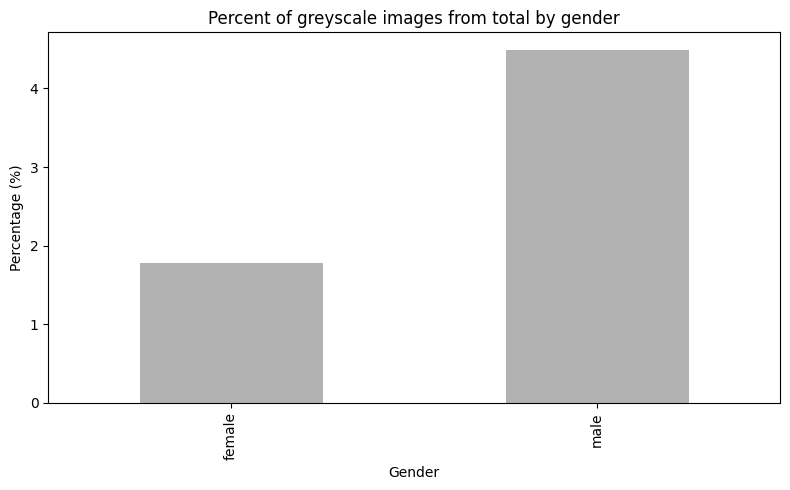

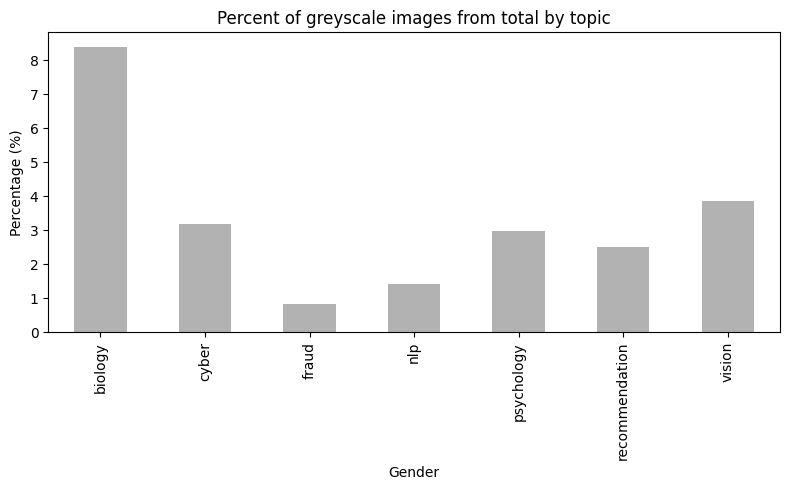

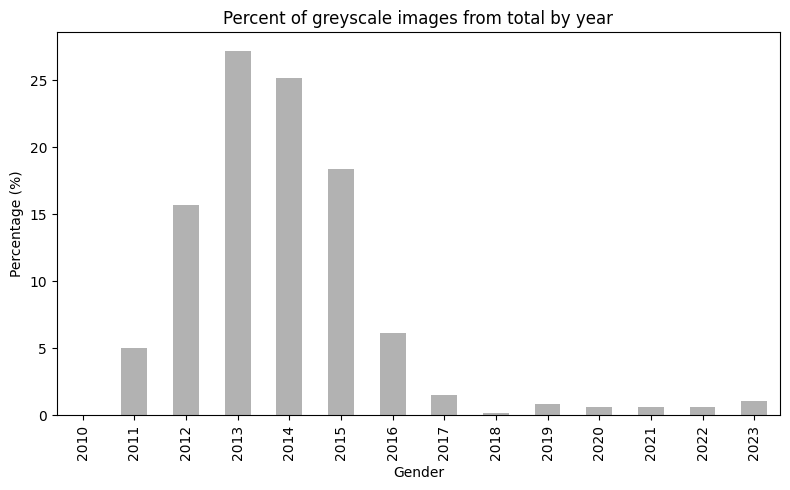

In [ ]:
def plot_grey_percent(group_name):
  grouped = full_df.groupby(group_name)["color_grey"].sum() / full_df.groupby(group_name)["color_grey"].count() * 100

  # Set up the figure and axes
  plt.figure(figsize=(8, 5))

  # Create a bar plot for percentage of True values from the total by gender
  grouped.plot(kind="bar", color='grey', alpha=0.6)

  # Set labels and title
  plt.xlabel("Gender")
  plt.ylabel("Percentage (%)")
  plt.title(f"Percent of greyscale images from total by {group_name}")

  # Show the plot
  plt.tight_layout()
  plt.show()

plot_grey_percent("gender")
plot_grey_percent("topic")
plot_grey_percent("year")

# Extract Images From URL and Convert to Vectors

In [ ]:
!mkdir images

In [ ]:
for i, r in full_df.iterrows():
    image_url = r['figure_link']
    !wget -O 'images/image_{i}.jpg' '{image_url}'

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
lst = os.listdir('/content/drive/MyDrive/images')
number_files = len(lst)
print(number_files)

6000


In [ ]:
def get_image_paths(directory):
    image_paths = glob.glob(os.path.join(directory, '**', '*.jpg'), recursive=True)
    image_paths.extend(glob.glob(os.path.join(directory, '**', '*.png'), recursive=True))
    return image_paths

image_paths = get_image_paths("/content/drive/MyDrive/images")

In [ ]:
# Create column for the images vector
full_df['image_vector'] = None

In [ ]:
failed_lst = []

def images_to_vectors(image_paths):
    # Check if a GPU is available and move the model to GPU if possible
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load the pre-trained vision model
    model = vgg16(pretrained=True)
    model = model.to(device)
    model.eval()

    vectors = []

    succeed = 0
    failed = 0

    for image_path in image_paths:
      row_number = int(image_path.split('_')[1].split('.')[0])
      try:
        # Load the image
        image = Image.open(image_path).convert("RGB")

        # Preprocess the image
        preprocess = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        input_tensor = preprocess(image)
        input_batch = input_tensor.unsqueeze(0)

        # Pass the input through the model and obtain the embeddings
        with torch.no_grad():
            input_batch = input_batch.to(device)
            embeddings = model(input_batch)

        # Flatten the embeddings to obtain a vector representation
        vector = embeddings.view(embeddings.size(0), -1)

        # Convert the vector to a numpy array
        vector = vector.detach().cpu().numpy()

        # Insert the vector to the dataframe
        full_df.at[row_number, 'image_vector'] = vector

        vectors.append(vector)
        succeed += 1

      except:
        failed += 1
        failed_lst.append(row_number)

    print('succeded: ' + str(succeed))
    print('failed: ' + str(failed))
    return vectors

vectors = images_to_vectors(image_paths)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


succeded: 6000
failed: 0


In [ ]:
full_df.to_csv('dataset_6000_images_vector.csv', index=False)

## Create Features Dataframe

In [3]:
full_df = pd.read_csv('/content/dataset_6000_images_vector.csv', index_col=0, encoding='unicode_escape')
full_df['image_vector'] = full_df['image_vector'].str.strip('[]')
full_df['image_vector'] = full_df['image_vector'].str.split()

In [4]:
new_df = full_df.filter(['year', 'topic', 'gender', 'image_vector'], axis=1)

vectors = new_df['image_vector']
vectors = [[v] for v in vectors]

In [5]:
float_lists = []
for vec in vectors:
  float_list = []
  for i in range(len(vec)):
    float_vec = []
    for item in vec[i]:
      float_vec.append(float(item))
    float_list.append(float_vec)
  float_lists.append(np.array(float_list))

In [6]:
vecs = float_lists

In [7]:
vectors2 = [list(v[0]) for v in vecs]
col_names = [f"feature {i}" for i in range(len(vectors2[0]))]

df_vec = pd.DataFrame(vectors2, columns=col_names)
df_vec

,feature 0,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6,feature 7,feature 8,feature 9,...,feature 990,feature 991,feature 992,feature 993,feature 994,feature 995,feature 996,feature 997,feature 998,feature 999
0,-2.972674,-3.047310,-2.126097,-3.527888,-2.712270,-1.683633,-4.031274,-1.427207,-1.740036,-1.935419,...,-0.839351,-2.134200,-5.963789,-2.179673,-4.551397,-2.014676,-0.368375,-5.364916,0.572040,2.298274
1,-1.644412,-1.086765,-1.011632,-2.495976,-0.846086,-0.623605,-2.315911,-2.251968,-2.357715,-4.197502,...,-0.422726,-2.553038,-1.720814,-1.756415,-2.858241,-0.795387,0.370200,-3.360076,0.554196,3.837938
2,-1.534068,-0.935432,-0.422487,-2.035745,-0.808009,-0.114899,-1.942848,-1.927812,-1.787214,-2.613806,...,-0.660055,-2.449719,-3.390114,-1.746720,-2.846321,-2.697180,-1.034146,-3.567086,0.926263,4.189312
3,-3.320873,0.231886,-3.766049,-3.075788,-1.044822,0.564748,-1.261342,-2.391707,-2.024328,-2.155904,...,1.315605,-1.809098,-1.387799,-0.889132,-2.322804,1.105262,1.241995,-3.001455,-1.033573,2.062096
4,-2.830678,-2.345222,-0.837328,-1.759640,0.619108,1.096032,-1.500534,-2.031827,-2.386603,-0.188144,...,-0.220477,-0.873378,-4.270846,-3.013299,-2.686005,-1.344088,-1.284419,-4.193632,0.851734,1.448803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,-3.777776,-2.853549,-3.329462,-0.437348,-0.110610,3.165693,-0.185102,-3.745954,-4.587151,-4.787772,...,-2.007631,-2.240091,-3.832179,-1.213215,-1.827963,-0.535734,-0.811988,-1.872801,0.189452,8.302977
5996,-3.036834,-1.759813,-0.770050,-0.488117,1.264974,1.337877,-1.217332,-0.069135,-1.102958,-2.298857,...,1.437064,-0.132439,-3.452592,-1.388870,-3.831133,0.500158,1.137484,-4.370120,-2.392373,1.711594
5997,-1.855752,-1.559144,-2.684390,-3.335156,-0.344629,1.209395,-4.198448,-2.256841,-2.328968,-1.738955,...,0.080044,-1.588414,-2.975186,-0.287263,-3.033630,-0.570579,0.526134,-3.444198,1.089184,1.060454
5998,-4.812837,-1.857750,-4.101128,-3.543423,-2.329000,0.413079,-1.881645,-3.999708,-3.006387,-1.200752,...,-1.013085,-2.415668,-2.586682,-2.586590,-3.218753,-2.073832,-1.773212,-3.677743,-0.496910,3.987324


In [8]:
features_df = pd.concat([new_df, df_vec], axis=1)
features_df = features_df.drop(columns=['image_vector'])
features_df

,year,topic,gender,feature 0,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6,...,feature 990,feature 991,feature 992,feature 993,feature 994,feature 995,feature 996,feature 997,feature 998,feature 999
0,2016,cyber,female,-2.972674,-3.047310,-2.126097,-3.527888,-2.712270,-1.683633,-4.031274,...,-0.839351,-2.134200,-5.963789,-2.179673,-4.551397,-2.014676,-0.368375,-5.364916,0.572040,2.298274
1,2020,vision,female,-1.644412,-1.086765,-1.011632,-2.495976,-0.846086,-0.623605,-2.315911,...,-0.422726,-2.553038,-1.720814,-1.756415,-2.858241,-0.795387,0.370200,-3.360076,0.554196,3.837938
2,2013,biology,male,-1.534068,-0.935432,-0.422487,-2.035745,-0.808009,-0.114899,-1.942848,...,-0.660055,-2.449719,-3.390114,-1.746720,-2.846321,-2.697180,-1.034146,-3.567086,0.926263,4.189312
3,2018,cyber,male,-3.320873,0.231886,-3.766049,-3.075788,-1.044822,0.564748,-1.261342,...,1.315605,-1.809098,-1.387799,-0.889132,-2.322804,1.105262,1.241995,-3.001455,-1.033573,2.062096
4,2018,psychology,male,-2.830678,-2.345222,-0.837328,-1.759640,0.619108,1.096032,-1.500534,...,-0.220477,-0.873378,-4.270846,-3.013299,-2.686005,-1.344088,-1.284419,-4.193632,0.851734,1.448803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,2017,cyber,male,-3.777776,-2.853549,-3.329462,-0.437348,-0.110610,3.165693,-0.185102,...,-2.007631,-2.240091,-3.832179,-1.213215,-1.827963,-0.535734,-0.811988,-1.872801,0.189452,8.302977
5996,2017,vision,male,-3.036834,-1.759813,-0.770050,-0.488117,1.264974,1.337877,-1.217332,...,1.437064,-0.132439,-3.452592,-1.388870,-3.831133,0.500158,1.137484,-4.370120,-2.392373,1.711594
5997,2020,cyber,male,-1.855752,-1.559144,-2.684390,-3.335156,-0.344629,1.209395,-4.198448,...,0.080044,-1.588414,-2.975186,-0.287263,-3.033630,-0.570579,0.526134,-3.444198,1.089184,1.060454
5998,2017,vision,female,-4.812837,-1.857750,-4.101128,-3.543423,-2.329000,0.413079,-1.881645,...,-1.013085,-2.415668,-2.586682,-2.586590,-3.218753,-2.073832,-1.773212,-3.677743,-0.496910,3.987324


In [9]:
# Convert topic categorical values to numeric
encoded_df = pd.get_dummies(features_df, columns=['topic'], drop_first=True)

# Encoding year to ordinal values.
# Ordinal relationship between the years (e.g., trends or changes over time) might be relevant to the prediction task
label_encoder = LabelEncoder()
years = encoded_df['year']
ordinal_years = label_encoder.fit_transform(years)
encoded_df['ordinal_year'] = ordinal_years
encoded_df['class'] = label_encoder.fit_transform(encoded_df['gender'])
encoded_df = encoded_df.drop(['year', 'gender'], axis=1)

encoded_df

,feature 0,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6,feature 7,feature 8,feature 9,...,feature 998,feature 999,topic_cyber,topic_fraud,topic_nlp,topic_psychology,topic_recommendation,topic_vision,ordinal_year,class
0,-2.972674,-3.047310,-2.126097,-3.527888,-2.712270,-1.683633,-4.031274,-1.427207,-1.740036,-1.935419,...,0.572040,2.298274,1,0,0,0,0,0,6,0
1,-1.644412,-1.086765,-1.011632,-2.495976,-0.846086,-0.623605,-2.315911,-2.251968,-2.357715,-4.197502,...,0.554196,3.837938,0,0,0,0,0,1,10,0
2,-1.534068,-0.935432,-0.422487,-2.035745,-0.808009,-0.114899,-1.942848,-1.927812,-1.787214,-2.613806,...,0.926263,4.189312,0,0,0,0,0,0,3,1
3,-3.320873,0.231886,-3.766049,-3.075788,-1.044822,0.564748,-1.261342,-2.391707,-2.024328,-2.155904,...,-1.033573,2.062096,1,0,0,0,0,0,8,1
4,-2.830678,-2.345222,-0.837328,-1.759640,0.619108,1.096032,-1.500534,-2.031827,-2.386603,-0.188144,...,0.851734,1.448803,0,0,0,1,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,-3.777776,-2.853549,-3.329462,-0.437348,-0.110610,3.165693,-0.185102,-3.745954,-4.587151,-4.787772,...,0.189452,8.302977,1,0,0,0,0,0,7,1
5996,-3.036834,-1.759813,-0.770050,-0.488117,1.264974,1.337877,-1.217332,-0.069135,-1.102958,-2.298857,...,-2.392373,1.711594,0,0,0,0,0,1,7,1
5997,-1.855752,-1.559144,-2.684390,-3.335156,-0.344629,1.209395,-4.198448,-2.256841,-2.328968,-1.738955,...,1.089184,1.060454,1,0,0,0,0,0,10,1
5998,-4.812837,-1.857750,-4.101128,-3.543423,-2.329000,0.413079,-1.881645,-3.999708,-3.006387,-1.200752,...,-0.496910,3.987324,0,0,0,0,0,1,7,0


# Predict Author's Gender By Images

In [ ]:
X = encoded_df.drop(columns=['class'])
y = encoded_df['class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
model = CatBoostClassifier(iterations=1000, random_seed=42,
                          learning_rate=0.1,
                          depth=4)
model.fit(X_train, y_train)

0:	learn: 0.6651619	total: 207ms	remaining: 3m 26s
1:	learn: 0.6425311	total: 302ms	remaining: 2m 30s
2:	learn: 0.6246822	total: 398ms	remaining: 2m 12s
3:	learn: 0.6102869	total: 492ms	remaining: 2m 2s
4:	learn: 0.5988221	total: 594ms	remaining: 1m 58s
5:	learn: 0.5893113	total: 699ms	remaining: 1m 55s
6:	learn: 0.5817675	total: 796ms	remaining: 1m 52s
7:	learn: 0.5756844	total: 910ms	remaining: 1m 52s
8:	learn: 0.5696289	total: 1.01s	remaining: 1m 51s
9:	learn: 0.5652890	total: 1.12s	remaining: 1m 50s
10:	learn: 0.5616243	total: 1.31s	remaining: 1m 57s
11:	learn: 0.5585933	total: 1.51s	remaining: 2m 4s
12:	learn: 0.5562146	total: 1.7s	remaining: 2m 8s
13:	learn: 0.5541381	total: 1.88s	remaining: 2m 12s
14:	learn: 0.5524192	total: 2.07s	remaining: 2m 16s
15:	learn: 0.5500992	total: 2.25s	remaining: 2m 18s
16:	learn: 0.5488267	total: 2.43s	remaining: 2m 20s
17:	learn: 0.5467988	total: 2.63s	remaining: 2m 23s
18:	learn: 0.5456699	total: 2.81s	remaining: 2m 25s
19:	learn: 0.5441261	total

In [ ]:
y_predict = model.predict(X_test)

accuracy = accuracy_score(y_test,y_predict)
precision = precision_score(y_test, y_predict)
recall = recall_score(y_test, y_predict)
f1 = f1_score(y_test, y_predict)
print("Accuracy:" , accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Accuracy: 0.76
Precision: 0.7751322751322751
Recall: 0.9638157894736842
F1-Score: 0.8592375366568915


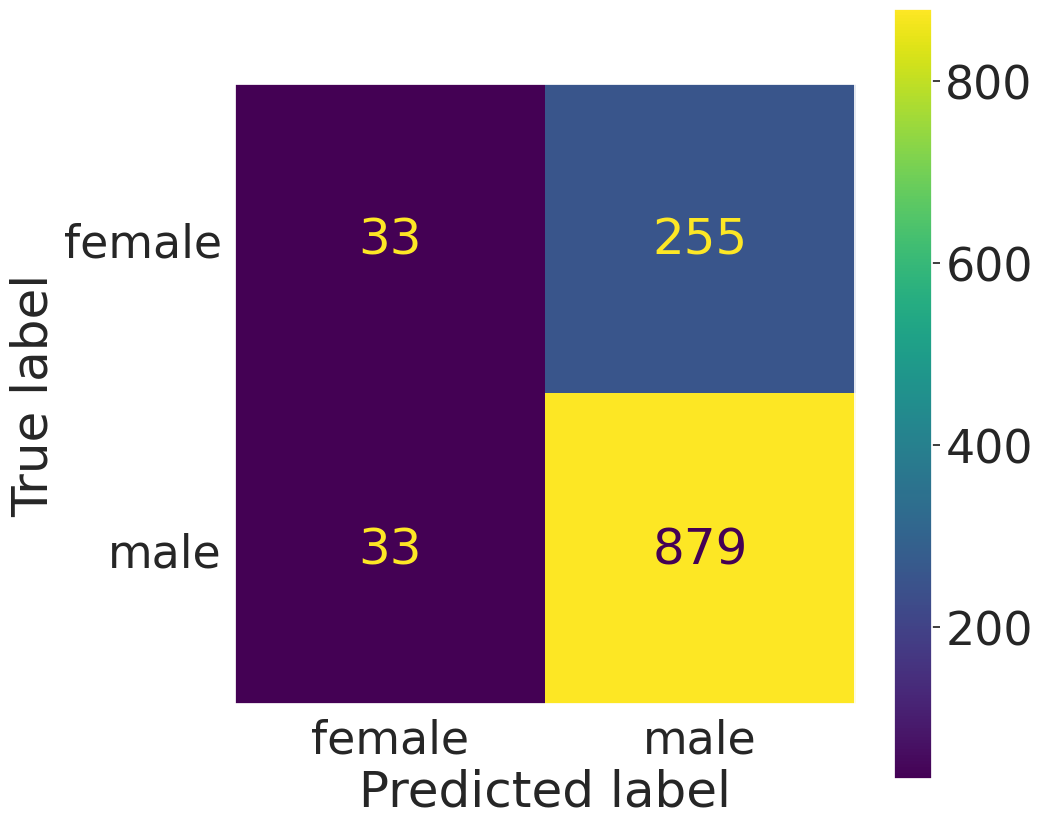

In [ ]:
cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["female", "male"])
fig, ax = plt.subplots(figsize=(10,10))

ax.grid(False)
disp.plot(ax=ax)


It appears that our model has achieved a high score and successfully predicted gender based on the paper images. However, our exploratory analysis revealed an imbalance in the target class (gender). In cases of imbalanced classes, relying solely on accuracy can be misleading and may lead to overfitting. Imbalanced datasets often cause models to exhibit bias toward the majority class.

## Cross-Validation

To address these challenges, we have employed cross-validation, a potent technique especially useful for addressing imbalanced target classes. Cross-validation offers a more dependable estimate of the model's performance by averaging results across multiple folds, thus mitigating the impact of random sampling variability. This approach enhances our ability to accurately gauge the model's potential to generalize to unseen data. Additionally, cross-validation aids in identifying overfitting by evaluating the model across various data subsets, leading to a more comprehensive comprehension of its ability to generalize. It also allows us to assess the model's effectiveness in handling both classes, ensuring predictions are not solely based on the majority class.

In [ ]:
my_model = CatBoostClassifier(iterations=1000, random_seed=42,
                          learning_rate=0.1,
                          depth=4)

# Perform cross-validation and get predicted probabilities
predicted_probabilities = cross_val_predict(my_model, X, y, cv=5, method='predict_proba')[:, 1]

0:	learn: 0.6648964	total: 282ms	remaining: 4m 42s
1:	learn: 0.6421968	total: 499ms	remaining: 4m 9s
2:	learn: 0.6240786	total: 718ms	remaining: 3m 58s
3:	learn: 0.6097582	total: 929ms	remaining: 3m 51s
4:	learn: 0.5975892	total: 1.15s	remaining: 3m 49s
5:	learn: 0.5883202	total: 1.37s	remaining: 3m 47s
6:	learn: 0.5807148	total: 1.6s	remaining: 3m 46s
7:	learn: 0.5740797	total: 1.81s	remaining: 3m 44s
8:	learn: 0.5689959	total: 2.02s	remaining: 3m 41s
9:	learn: 0.5647843	total: 2.19s	remaining: 3m 36s
10:	learn: 0.5615367	total: 2.43s	remaining: 3m 38s
11:	learn: 0.5573079	total: 2.64s	remaining: 3m 37s
12:	learn: 0.5547810	total: 2.84s	remaining: 3m 35s
13:	learn: 0.5525145	total: 3s	remaining: 3m 31s
14:	learn: 0.5507219	total: 3.11s	remaining: 3m 24s
15:	learn: 0.5491579	total: 3.24s	remaining: 3m 19s
16:	learn: 0.5469703	total: 3.35s	remaining: 3m 13s
17:	learn: 0.5456270	total: 3.46s	remaining: 3m 8s
18:	learn: 0.5441899	total: 3.58s	remaining: 3m 4s
19:	learn: 0.5431887	total: 3

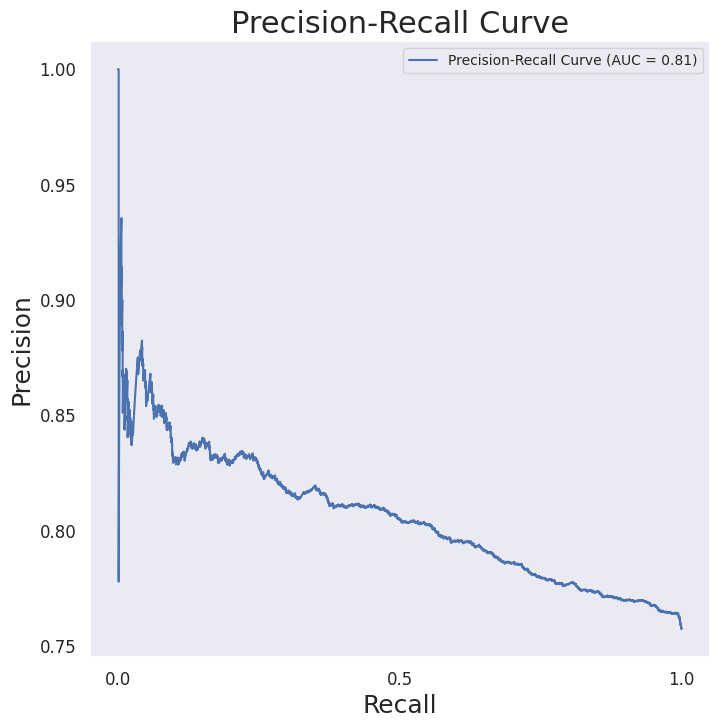

In [ ]:
# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y, predicted_probabilities)

# Calculate Area Under the Curve for PR curve
auc_score = auc(recall, precision)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 8))
plt.plot(recall, precision, label='Precision-Recall Curve (AUC = {:.2f})'.format(auc_score))
plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)
plt.title('Precision-Recall Curve', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(prop={"size":10})
plt.grid()
plt.show()

## Using Resampling

Another technique for dealing with imbalanced data is Synthetic Minority Over-sampling Technique (SMOTE), which generates synthetic samples for the minority class based on existing instances.

In [ ]:
print("Number of instances before SMOTE:")
print(y_train.value_counts())

smote = SMOTE(sampling_strategy=1, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print("Number of instances after SMOTE:")
print(y_resampled.value_counts())

# Train a model on the resampled data
model_resampled = CatBoostClassifier(iterations=1000,
                          learning_rate=0.1,
                          depth=4)
model_resampled.fit(X_resampled, y_resampled)

# Make predictions on the test data
y_pred = model_resampled.predict(X_test)

Number of instances before SMOTE:
male      3631
female    1169
Name: gender, dtype: int64
Number of instances after SMOTE:
male      3631
female    3631
Name: gender, dtype: int64
0:	learn: 0.6820021	total: 235ms	remaining: 3m 54s
1:	learn: 0.6719540	total: 363ms	remaining: 3m 1s
2:	learn: 0.6627322	total: 487ms	remaining: 2m 41s
3:	learn: 0.6517999	total: 595ms	remaining: 2m 28s
4:	learn: 0.6456515	total: 707ms	remaining: 2m 20s
5:	learn: 0.6419064	total: 814ms	remaining: 2m 14s
6:	learn: 0.6338655	total: 928ms	remaining: 2m 11s
7:	learn: 0.6310866	total: 1.07s	remaining: 2m 12s
8:	learn: 0.6285376	total: 1.2s	remaining: 2m 12s
9:	learn: 0.6258194	total: 1.31s	remaining: 2m 9s
10:	learn: 0.6226256	total: 1.42s	remaining: 2m 7s
11:	learn: 0.6204151	total: 1.51s	remaining: 2m 4s
12:	learn: 0.6180835	total: 1.63s	remaining: 2m 3s
13:	learn: 0.6160684	total: 1.73s	remaining: 2m 1s
14:	learn: 0.6139131	total: 1.83s	remaining: 2m
15:	learn: 0.6113660	total: 1.95s	remaining: 1m 59s
16:	lear

In [ ]:
# Evaluate the model
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

      female       0.29      0.18      0.22       288
        male       0.77      0.86      0.81       912

    accuracy                           0.70      1200
   macro avg       0.53      0.52      0.52      1200
weighted avg       0.65      0.70      0.67      1200



Based on the provided classification report:

- The model's performance on the 'female' class is relatively poor compared to the 'male' class. The low precision, recall, and F1-Score for the 'female' class indicate that the model struggles to correctly predict 'female' instances.

- The 'male' class has better precision, recall, and F1-Score, suggesting that the model is performing better for this class.

- The weighted average F1-Score (0.67) indicates the overall performance of the model, considering both classes. This average takes into account the class distribution.

## Class Balance

We also tried to balance the data to see how the model is performing when there is an equal sampling of both classes, in order to mitigate any bias towards the majority class and ensure a more equitable evaluation of the model's capabilities.







In [12]:
# Separate the majority and minority classes
majority_class = encoded_df[encoded_df['class'] == 1]
minority_class = encoded_df[encoded_df['class'] == 0]

# Downsample the majority class to match the minority class size
majority_downsampled = resample(majority_class,
                                replace=False,
                                n_samples=len(minority_class),
                                random_state=42)

# Combine the minority class with the downsampled majority class
balanced_df = pd.concat([majority_downsampled, minority_class])

# Shuffle the balanced dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
balanced_df

,feature 0,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6,feature 7,feature 8,feature 9,...,feature 998,feature 999,topic_cyber,topic_fraud,topic_nlp,topic_psychology,topic_recommendation,topic_vision,ordinal_year,class
0,-3.175508,-1.341914,-2.175836,-1.130996,1.651138,1.844438,-1.345887,-2.971404,-3.147923,-3.436073,...,-0.529681,2.429530,0,0,0,0,0,1,12,0
1,-2.485704,0.159646,-3.168750,-1.331378,-0.985549,-1.022202,0.818060,-4.204555,-3.287367,-3.723933,...,-0.254765,4.598504,0,0,0,0,1,0,8,0
2,-2.996374,-1.039487,-1.127122,-1.527129,0.757967,-0.788940,-1.816767,-2.011892,-2.455180,-2.251086,...,0.320340,4.652406,0,0,0,0,0,1,5,0
3,-0.849286,-1.866481,-1.599057,-2.593437,-2.681134,0.205923,-3.629752,0.661090,-0.693137,-2.460217,...,-1.301454,3.130348,0,0,0,0,1,0,7,1
4,-1.846954,-0.791272,-2.429956,-2.439642,-0.511620,2.571197,-1.770053,-3.172409,-2.801523,-2.815473,...,1.804867,2.824418,1,0,0,0,0,0,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2909,-0.929400,-0.489498,-2.681291,-2.197394,-2.054148,1.678249,-1.640670,-2.868832,-2.617958,-1.428475,...,0.482207,3.264157,0,1,0,0,0,0,10,0
2910,-1.989227,-1.564813,1.646634,-1.121355,0.805980,1.344834,-1.477788,-2.915014,-3.519798,-2.513670,...,0.998769,3.681875,0,0,0,0,1,0,6,1
2911,-2.903298,-1.095289,-1.173269,-0.590576,1.601039,3.485552,2.031528,-2.941604,-1.941524,-0.040725,...,0.971503,1.699842,0,0,0,0,0,1,11,1
2912,-1.209795,-1.730690,-1.356849,-2.785228,-2.329876,0.652071,-2.055815,-0.834365,-1.633023,-2.265009,...,-0.538243,1.918255,1,0,0,0,0,0,11,1


In [13]:
X_balanced = balanced_df.drop(columns=['class'])
y_balanced = balanced_df['class']

# Split the data into training and testing sets
X_balanced_train, X_balanced_test, y_balanced_train, y_balanced_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

### Hyperparameters Tuning

We'll try different hyperparameters to see which are giving us the best result

In [ ]:
hyperparameters_list = [
    {'iterations': 1000, 'depth': 4, 'learning_rate': 0.1, 'random_seed': 42},
    {'iterations': 1000, 'depth': 6, 'learning_rate': 0.01, 'random_seed': 42},
    {'iterations': 1000, 'depth': 4, 'learning_rate': 0.05, 'random_seed': 42},
    {'iterations': 1000, 'depth': 8, 'learning_rate': 0.001, 'random_seed': 42},
    {'iterations': 2000, 'depth': 4, 'learning_rate': 0.1, 'random_seed': 42},
    {'iterations': 3000, 'depth': 4, 'learning_rate': 0.1, 'random_seed': 42},
    {'iterations': 3000, 'depth': 4, 'learning_rate': 0.05, 'random_seed': 42},
    {'iterations': 3000, 'depth': 6, 'learning_rate': 0.1, 'random_seed': 42},
    {'iterations': 4000, 'depth': 4, 'learning_rate': 0.1, 'random_seed': 42},
]

best_f1_score = 0.0
best_hyperparameters = None

# Loop through each set of hyperparameters
for hyperparameters in hyperparameters_list:
    # Train the CatBoost model with the current hyperparameters
    model_params = CatBoostClassifier(**hyperparameters)
    model_params.fit(X_balanced_train, y_balanced_train)

    y_params_pred = model_params.predict(X_balanced_test)

    current_f1_score = f1_score(y_balanced_test, y_params_pred)

    # Check if the current hyperparameters yield a better F1-score
    if current_f1_score > best_f1_score:
        best_f1_score = current_f1_score
        best_hyperparameters = hyperparameters

print("Best F1-score:", best_f1_score)
print("Best Hyperparameters:", best_hyperparameters)

We found that the best parameters are: `{'iterations': 3000, 'depth': 4, 'learning_rate': 0.1, 'random_seed': 42}` with F1-score of `0.5686`

In [61]:
model_balanced = CatBoostClassifier(iterations=3000, random_seed=42,
                          learning_rate=0.1,
                          depth=4)
model_balanced.fit(X_balanced_train, y_balanced_train)

0:	learn: 0.6910453	total: 346ms	remaining: 17m 18s
1:	learn: 0.6886126	total: 597ms	remaining: 14m 55s
2:	learn: 0.6855316	total: 858ms	remaining: 14m 17s
3:	learn: 0.6834402	total: 1.05s	remaining: 13m 5s
4:	learn: 0.6820067	total: 1.22s	remaining: 12m 12s
5:	learn: 0.6804844	total: 1.41s	remaining: 11m 44s
6:	learn: 0.6787088	total: 1.59s	remaining: 11m 19s
7:	learn: 0.6772251	total: 1.77s	remaining: 11m 1s
8:	learn: 0.6748599	total: 1.95s	remaining: 10m 47s
9:	learn: 0.6718084	total: 2.11s	remaining: 10m 30s
10:	learn: 0.6700797	total: 2.28s	remaining: 10m 18s
11:	learn: 0.6680341	total: 2.47s	remaining: 10m 14s
12:	learn: 0.6668557	total: 2.67s	remaining: 10m 14s
13:	learn: 0.6651126	total: 2.81s	remaining: 9m 59s
14:	learn: 0.6625228	total: 2.97s	remaining: 9m 50s
15:	learn: 0.6608062	total: 3.13s	remaining: 9m 43s
16:	learn: 0.6594803	total: 3.3s	remaining: 9m 39s
17:	learn: 0.6577575	total: 3.4s	remaining: 9m 24s
18:	learn: 0.6560711	total: 3.5s	remaining: 9m 9s
19:	learn: 0.65

In [62]:
y_balanced_pred = model_balanced.predict(X_balanced_test)

report = classification_report(y_balanced_test, y_balanced_pred)
print(report)

              precision    recall  f1-score   support

           0       0.53      0.56      0.55       277
           1       0.58      0.56      0.57       306

    accuracy                           0.56       583
   macro avg       0.56      0.56      0.56       583
weighted avg       0.56      0.56      0.56       583



In [63]:
accuracy = accuracy_score(y_balanced_test,y_balanced_pred)
precision = precision_score(y_balanced_test,y_balanced_pred)
recall = recall_score(y_balanced_test,y_balanced_pred)
f1 = f1_score(y_balanced_test,y_balanced_pred)
print("Accuracy:" , accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Accuracy: 0.5574614065180102
Precision: 0.5821917808219178
Recall: 0.5555555555555556
F1-Score: 0.568561872909699


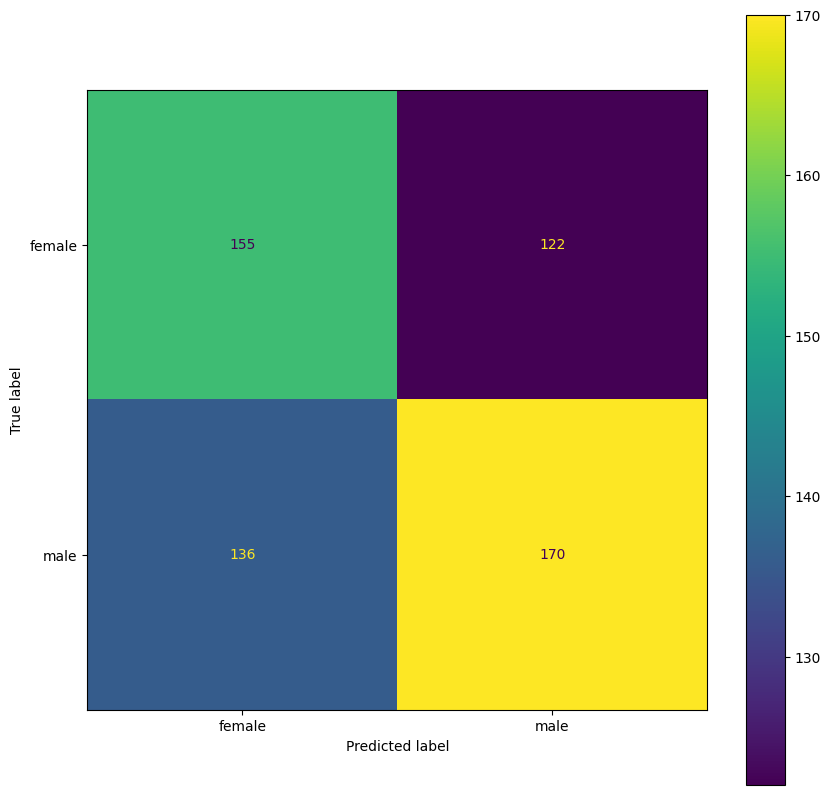

In [64]:
cm = confusion_matrix(y_balanced_test, y_balanced_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["female", "male"])
fig, ax = plt.subplots(figsize=(10,10))

ax.grid(False)
disp.plot(ax=ax)

###Ensemble Model

Trying improve prediction performance using ensemble

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

# Create base models
base_models = [
    ('catboost', CatBoostClassifier(iterations=3000, depth=4, learning_rate=0.1)),
    ('rf', RandomForestClassifier()),
    ('svc', SVC(probability=True))
]

# Create a stacking ensemble model
stacking_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())

# Train the stacking model on the train set
stacking_model.fit(X_balanced_train, y_balanced_train)

# Make predictions on the test set
y_stack_pred = stacking_model.predict(X_balanced_test)

Streaming output truncated to the last 5000 lines.
1000:	learn: 0.0233462	total: 1m 57s	remaining: 3m 54s
1001:	learn: 0.0232831	total: 1m 57s	remaining: 3m 54s
1002:	learn: 0.0231820	total: 1m 57s	remaining: 3m 53s
1003:	learn: 0.0230942	total: 1m 57s	remaining: 3m 53s
1004:	learn: 0.0230169	total: 1m 57s	remaining: 3m 53s
1005:	learn: 0.0229703	total: 1m 57s	remaining: 3m 53s
1006:	learn: 0.0229225	total: 1m 57s	remaining: 3m 53s
1007:	learn: 0.0228597	total: 1m 58s	remaining: 3m 53s
1008:	learn: 0.0228174	total: 1m 58s	remaining: 3m 53s
1009:	learn: 0.0227711	total: 1m 58s	remaining: 3m 52s
1010:	learn: 0.0227024	total: 1m 58s	remaining: 3m 52s
1011:	learn: 0.0226498	total: 1m 58s	remaining: 3m 52s
1012:	learn: 0.0225643	total: 1m 58s	remaining: 3m 52s
1013:	learn: 0.0224973	total: 1m 58s	remaining: 3m 52s
1014:	learn: 0.0224339	total: 1m 58s	remaining: 3m 52s
1015:	learn: 0.0223734	total: 1m 58s	remaining: 3m 52s
1016:	learn: 0.0223209	total: 1m 59s	remaining: 3m 52s
1017:	learn: 0

In [66]:
# Evaluate the model
report = classification_report(y_balanced_test, y_stack_pred)
print(report)

              precision    recall  f1-score   support

           0       0.53      0.60      0.56       277
           1       0.59      0.51      0.55       306

    accuracy                           0.55       583
   macro avg       0.56      0.56      0.55       583
weighted avg       0.56      0.55      0.55       583



In [67]:
accuracy = accuracy_score(y_balanced_test,y_stack_pred)
precision = precision_score(y_balanced_test,y_stack_pred)
recall = recall_score(y_balanced_test,y_stack_pred)
f1 = f1_score(y_balanced_test,y_stack_pred)
print("Accuracy:" , accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Accuracy: 0.5540308747855918
Precision: 0.585820895522388
Recall: 0.5130718954248366
F1-Score: 0.5470383275261324


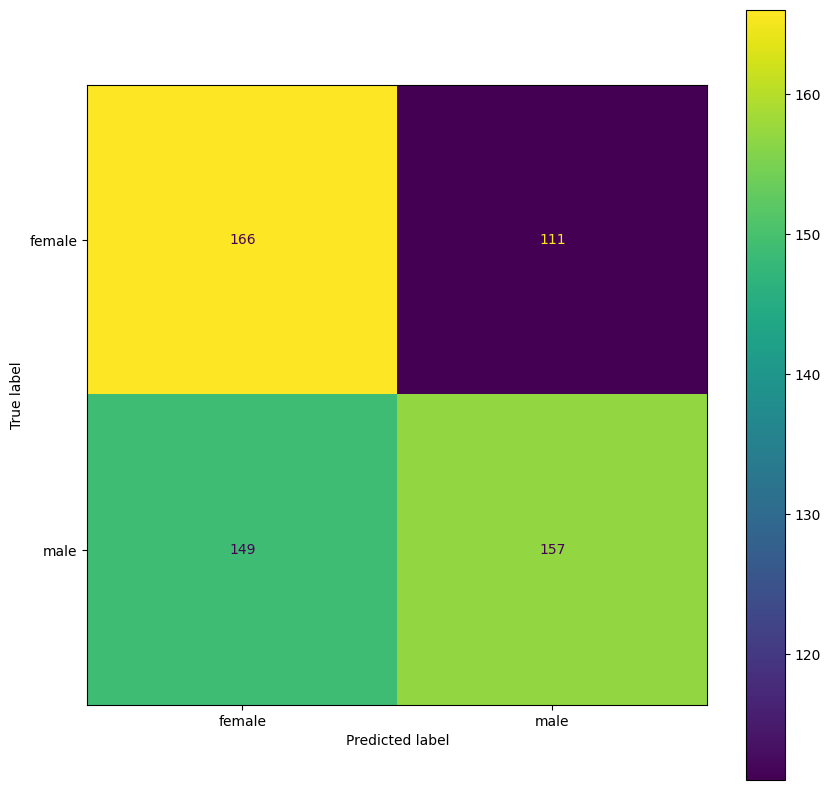

In [68]:
cm = confusion_matrix(y_balanced_test, y_stack_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["female", "male"])
fig, ax = plt.subplots(figsize=(10,10))

ax.grid(False)
disp.plot(ax=ax)

### Exploring Feature Importance using SHAP

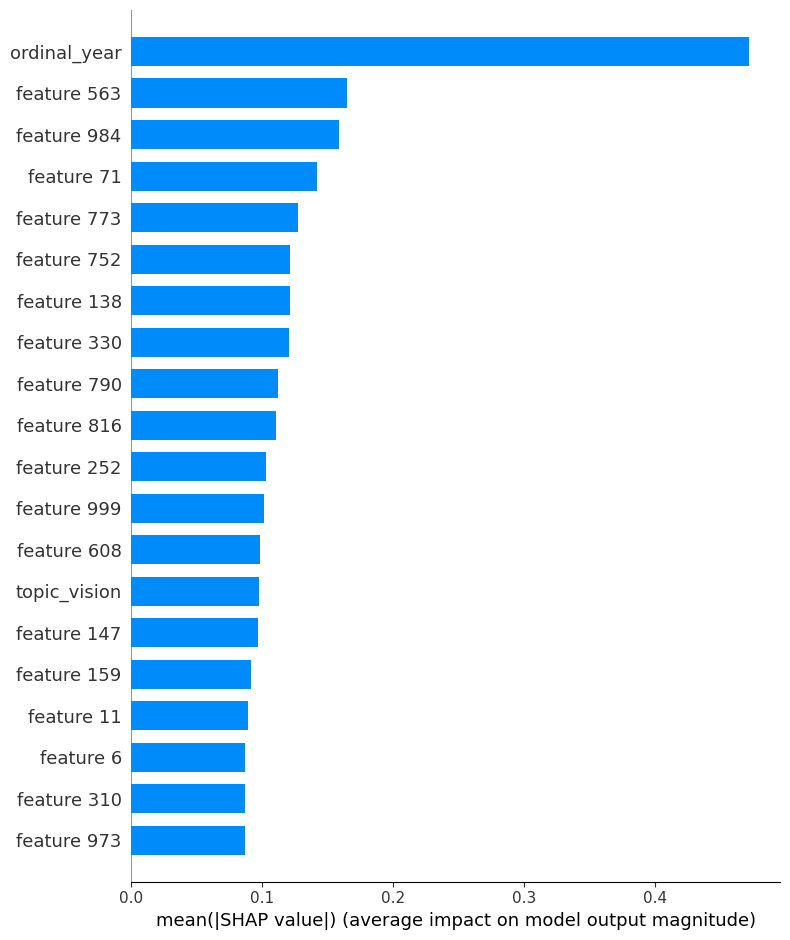

In [69]:
explainer = shap.Explainer(model_balanced)

# Calculate SHAP values
shap_values = explainer(X_balanced_test)

# Plot feature importance summary
shap.summary_plot(shap_values, X_balanced_test, plot_type="bar")

We see that the most influence features is the year, and since the model is not performing very well, we'll try to train the model without the year feature.

In [70]:
X_balanced_new = balanced_df.drop(columns=['class', 'ordinal_year'])
y_balanced_new = balanced_df['class']

# Split the data into training and testing sets
X_balanced_new_train, X_balanced_new_test, y_balanced_new_train, y_balanced_new_test = train_test_split(X_balanced_new, y_balanced_new, test_size=0.2, random_state=42)

In [71]:
model_balanced_new = CatBoostClassifier(iterations=3000, random_seed=42,
                          learning_rate=0.1,
                          depth=4)
model_balanced_new.fit(X_balanced_new_train, y_balanced_new_train)

0:	learn: 0.6914428	total: 131ms	remaining: 6m 32s
1:	learn: 0.6894948	total: 231ms	remaining: 5m 46s
2:	learn: 0.6871586	total: 325ms	remaining: 5m 24s
3:	learn: 0.6862942	total: 444ms	remaining: 5m 32s
4:	learn: 0.6842294	total: 549ms	remaining: 5m 28s
5:	learn: 0.6822294	total: 658ms	remaining: 5m 28s
6:	learn: 0.6808281	total: 759ms	remaining: 5m 24s
7:	learn: 0.6789719	total: 856ms	remaining: 5m 20s
8:	learn: 0.6760002	total: 979ms	remaining: 5m 25s
9:	learn: 0.6741602	total: 1.08s	remaining: 5m 23s
10:	learn: 0.6718391	total: 1.19s	remaining: 5m 23s
11:	learn: 0.6696599	total: 1.29s	remaining: 5m 21s
12:	learn: 0.6681644	total: 1.4s	remaining: 5m 20s
13:	learn: 0.6669682	total: 1.52s	remaining: 5m 24s
14:	learn: 0.6657197	total: 1.63s	remaining: 5m 24s
15:	learn: 0.6643877	total: 1.74s	remaining: 5m 25s
16:	learn: 0.6630356	total: 1.85s	remaining: 5m 23s
17:	learn: 0.6612363	total: 1.97s	remaining: 5m 26s
18:	learn: 0.6599096	total: 2.08s	remaining: 5m 26s
19:	learn: 0.6588656	to

In [72]:
y_balanced_new_pred = model_balanced_new.predict(X_balanced_new_test)

accuracy = accuracy_score(y_balanced_new_test,y_balanced_new_pred)
precision = precision_score(y_balanced_new_test,y_balanced_new_pred)
recall = recall_score(y_balanced_new_test,y_balanced_new_pred)
f1 = f1_score(y_balanced_new_test,y_balanced_new_pred)
print("Accuracy:" , accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Accuracy: 0.5248713550600344
Precision: 0.5498281786941581
Recall: 0.5228758169934641
F1-Score: 0.5360134003350083


### Image Vector Features Only

We saw that even without the ordinal_year feature, the model performance is not improve. We'll try to use only the image vector (features 1-1000 that construct the image vector) to predict the gender.

In [73]:
balanced_vectors_df = balanced_df.loc[:, 'feature 0':'feature 999']
balanced_vectors_df

,feature 0,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6,feature 7,feature 8,feature 9,...,feature 990,feature 991,feature 992,feature 993,feature 994,feature 995,feature 996,feature 997,feature 998,feature 999
0,-3.175508,-1.341914,-2.175836,-1.130996,1.651138,1.844438,-1.345887,-2.971404,-3.147923,-3.436073,...,-0.529569,0.406111,-1.606565,-0.186743,-2.819852,-0.581094,1.415916,-2.748654,-0.529681,2.429530
1,-2.485704,0.159646,-3.168750,-1.331378,-0.985549,-1.022202,0.818060,-4.204555,-3.287367,-3.723933,...,-0.223649,-3.083395,-4.748152,-3.659638,-3.755868,-2.705701,-0.806282,-4.650139,-0.254765,4.598504
2,-2.996374,-1.039487,-1.127122,-1.527129,0.757967,-0.788940,-1.816767,-2.011892,-2.455180,-2.251086,...,-0.288611,-0.773558,-3.649570,-2.261513,-2.829834,-1.546316,-0.495152,-3.926127,0.320340,4.652406
3,-0.849286,-1.866481,-1.599057,-2.593437,-2.681134,0.205923,-3.629752,0.661090,-0.693137,-2.460217,...,0.036064,-3.693220,-4.669640,-1.043860,-3.506335,-2.354602,-1.143954,-3.418027,-1.301454,3.130348
4,-1.846954,-0.791272,-2.429956,-2.439642,-0.511620,2.571197,-1.770053,-3.172409,-2.801523,-2.815473,...,-2.447353,-1.021304,-2.356680,0.305098,-1.828625,-0.918138,0.827270,-3.003878,1.804867,2.824418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2909,-0.929400,-0.489498,-2.681291,-2.197394,-2.054148,1.678249,-1.640670,-2.868832,-2.617958,-1.428475,...,1.144185,-1.661748,-1.197551,-0.025269,-0.949605,0.127761,1.810962,-1.010579,0.482207,3.264157
2910,-1.989227,-1.564813,1.646634,-1.121355,0.805980,1.344834,-1.477788,-2.915014,-3.519798,-2.513670,...,-0.953684,-2.214095,-4.060574,-3.417640,-3.477459,-1.737402,-2.017840,-3.903857,0.998769,3.681875
2911,-2.903298,-1.095289,-1.173269,-0.590576,1.601039,3.485552,2.031528,-2.941604,-1.941524,-0.040725,...,3.049475,-0.091316,-0.428884,-0.952145,-1.504765,1.006378,1.111980,0.228311,0.971503,1.699842
2912,-1.209795,-1.730690,-1.356849,-2.785228,-2.329876,0.652071,-2.055815,-0.834365,-1.633023,-2.265009,...,-0.481214,-2.588792,-4.042359,-2.973804,-3.357218,-2.020493,-1.761370,-3.060857,-0.538243,1.918255


In [74]:
X_balanced_vector = balanced_vectors_df
y_balanced_vector = balanced_df['class']

# Split the data into training and testing sets
X_balanced_vector_train, X_balanced_vector_test, y_balanced_vector_train, y_balanced_vector_test = train_test_split(X_balanced_vector, y_balanced_vector, test_size=0.2, random_state=42)

model_balanced_vector = CatBoostClassifier(iterations=3000, random_seed=42,
                          learning_rate=0.1,
                          depth=4)
model_balanced_vector.fit(X_balanced_vector_train, y_balanced_vector_train)

0:	learn: 0.6912875	total: 173ms	remaining: 8m 39s
1:	learn: 0.6883997	total: 278ms	remaining: 6m 56s
2:	learn: 0.6862919	total: 383ms	remaining: 6m 22s
3:	learn: 0.6848714	total: 491ms	remaining: 6m 7s
4:	learn: 0.6826709	total: 593ms	remaining: 5m 54s
5:	learn: 0.6811205	total: 717ms	remaining: 5m 57s
6:	learn: 0.6795409	total: 821ms	remaining: 5m 51s
7:	learn: 0.6778441	total: 919ms	remaining: 5m 43s
8:	learn: 0.6759360	total: 1.02s	remaining: 5m 38s
9:	learn: 0.6746148	total: 1.12s	remaining: 5m 35s
10:	learn: 0.6730702	total: 1.25s	remaining: 5m 38s
11:	learn: 0.6705582	total: 1.35s	remaining: 5m 35s
12:	learn: 0.6688284	total: 1.47s	remaining: 5m 37s
13:	learn: 0.6674558	total: 1.57s	remaining: 5m 35s
14:	learn: 0.6657002	total: 1.68s	remaining: 5m 34s
15:	learn: 0.6643515	total: 1.79s	remaining: 5m 33s
16:	learn: 0.6622648	total: 1.89s	remaining: 5m 32s
17:	learn: 0.6613861	total: 2s	remaining: 5m 31s
18:	learn: 0.6595397	total: 2.1s	remaining: 5m 29s
19:	learn: 0.6580232	total:

In [75]:
y_balanced_vector_pred = model_balanced_vector.predict(X_balanced_vector_test)

accuracy = accuracy_score(y_balanced_vector_test,y_balanced_vector_pred)
precision = precision_score(y_balanced_vector_test,y_balanced_vector_pred)
recall = recall_score(y_balanced_vector_test,y_balanced_vector_pred)
f1 = f1_score(y_balanced_vector_test,y_balanced_vector_pred)
print("Accuracy:" , accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Accuracy: 0.5694682675814752
Precision: 0.5913621262458472
Recall: 0.5816993464052288
F1-Score: 0.586490939044481


The model still didn't improve its prediction much

# Predict Topic By Images

We also tried to predict the topic using the images vector features and the gender

In [21]:
topic_df = features_df

topic_df = pd.get_dummies(features_df, columns=['gender'], drop_first=False)

label_encoder = LabelEncoder()
years = topic_df['year']
ordinal_years = label_encoder.fit_transform(years)
topic_df['ordinal_year'] = ordinal_years
# topic_df['class'] = label_encoder.fit_transform(topic_df['topic'])
topic_df = topic_df.drop(['year'], axis=1)

topic_df

,topic,feature 0,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6,feature 7,feature 8,...,feature 993,feature 994,feature 995,feature 996,feature 997,feature 998,feature 999,gender_female,gender_male,ordinal_year
0,cyber,-2.972674,-3.047310,-2.126097,-3.527888,-2.712270,-1.683633,-4.031274,-1.427207,-1.740036,...,-2.179673,-4.551397,-2.014676,-0.368375,-5.364916,0.572040,2.298274,1,0,6
1,vision,-1.644412,-1.086765,-1.011632,-2.495976,-0.846086,-0.623605,-2.315911,-2.251968,-2.357715,...,-1.756415,-2.858241,-0.795387,0.370200,-3.360076,0.554196,3.837938,1,0,10
2,biology,-1.534068,-0.935432,-0.422487,-2.035745,-0.808009,-0.114899,-1.942848,-1.927812,-1.787214,...,-1.746720,-2.846321,-2.697180,-1.034146,-3.567086,0.926263,4.189312,0,1,3
3,cyber,-3.320873,0.231886,-3.766049,-3.075788,-1.044822,0.564748,-1.261342,-2.391707,-2.024328,...,-0.889132,-2.322804,1.105262,1.241995,-3.001455,-1.033573,2.062096,0,1,8
4,psychology,-2.830678,-2.345222,-0.837328,-1.759640,0.619108,1.096032,-1.500534,-2.031827,-2.386603,...,-3.013299,-2.686005,-1.344088,-1.284419,-4.193632,0.851734,1.448803,0,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,cyber,-3.777776,-2.853549,-3.329462,-0.437348,-0.110610,3.165693,-0.185102,-3.745954,-4.587151,...,-1.213215,-1.827963,-0.535734,-0.811988,-1.872801,0.189452,8.302977,0,1,7
5996,vision,-3.036834,-1.759813,-0.770050,-0.488117,1.264974,1.337877,-1.217332,-0.069135,-1.102958,...,-1.388870,-3.831133,0.500158,1.137484,-4.370120,-2.392373,1.711594,0,1,7
5997,cyber,-1.855752,-1.559144,-2.684390,-3.335156,-0.344629,1.209395,-4.198448,-2.256841,-2.328968,...,-0.287263,-3.033630,-0.570579,0.526134,-3.444198,1.089184,1.060454,0,1,10
5998,vision,-4.812837,-1.857750,-4.101128,-3.543423,-2.329000,0.413079,-1.881645,-3.999708,-3.006387,...,-2.586590,-3.218753,-2.073832,-1.773212,-3.677743,-0.496910,3.987324,1,0,7


In [22]:
topic_df['class'] = label_encoder.fit_transform(topic_df['topic'])

# Get the mapping of encoded values to original class labels
class_mapping = {encoded_value: original_label for original_label, encoded_value in zip(topic_df['topic'], label_encoder.transform(topic_df['topic']))}

print(class_mapping)

{1: 'cyber', 6: 'vision', 0: 'biology', 4: 'psychology', 5: 'recommendation', 2: 'fraud', 3: 'nlp'}


In [24]:
topic_df = topic_df.drop(['topic'], axis=1)
topic_df

,feature 0,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6,feature 7,feature 8,feature 9,...,feature 994,feature 995,feature 996,feature 997,feature 998,feature 999,gender_female,gender_male,ordinal_year,class
0,-2.972674,-3.047310,-2.126097,-3.527888,-2.712270,-1.683633,-4.031274,-1.427207,-1.740036,-1.935419,...,-4.551397,-2.014676,-0.368375,-5.364916,0.572040,2.298274,1,0,6,1
1,-1.644412,-1.086765,-1.011632,-2.495976,-0.846086,-0.623605,-2.315911,-2.251968,-2.357715,-4.197502,...,-2.858241,-0.795387,0.370200,-3.360076,0.554196,3.837938,1,0,10,6
2,-1.534068,-0.935432,-0.422487,-2.035745,-0.808009,-0.114899,-1.942848,-1.927812,-1.787214,-2.613806,...,-2.846321,-2.697180,-1.034146,-3.567086,0.926263,4.189312,0,1,3,0
3,-3.320873,0.231886,-3.766049,-3.075788,-1.044822,0.564748,-1.261342,-2.391707,-2.024328,-2.155904,...,-2.322804,1.105262,1.241995,-3.001455,-1.033573,2.062096,0,1,8,1
4,-2.830678,-2.345222,-0.837328,-1.759640,0.619108,1.096032,-1.500534,-2.031827,-2.386603,-0.188144,...,-2.686005,-1.344088,-1.284419,-4.193632,0.851734,1.448803,0,1,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,-3.777776,-2.853549,-3.329462,-0.437348,-0.110610,3.165693,-0.185102,-3.745954,-4.587151,-4.787772,...,-1.827963,-0.535734,-0.811988,-1.872801,0.189452,8.302977,0,1,7,1
5996,-3.036834,-1.759813,-0.770050,-0.488117,1.264974,1.337877,-1.217332,-0.069135,-1.102958,-2.298857,...,-3.831133,0.500158,1.137484,-4.370120,-2.392373,1.711594,0,1,7,6
5997,-1.855752,-1.559144,-2.684390,-3.335156,-0.344629,1.209395,-4.198448,-2.256841,-2.328968,-1.738955,...,-3.033630,-0.570579,0.526134,-3.444198,1.089184,1.060454,0,1,10,1
5998,-4.812837,-1.857750,-4.101128,-3.543423,-2.329000,0.413079,-1.881645,-3.999708,-3.006387,-1.200752,...,-3.218753,-2.073832,-1.773212,-3.677743,-0.496910,3.987324,1,0,7,6


In [11]:
X_topic = topic_df.drop(columns=['class'])
y_topic = topic_df['class']

# Split the data into training and testing sets
X_topic_train, X_topic_test, y_topic_train, y_topic_test = train_test_split(X_topic, y_topic, test_size=0.2, random_state=42)

In [36]:
topic_model = CatBoostClassifier(iterations=3000, random_seed=42,
                          learning_rate=0.1,
                          depth=4)
topic_model.fit(X_topic_train, y_topic_train)

0:	learn: 1.9162383	total: 2.48s	remaining: 2h 4m 9s
1:	learn: 1.8901956	total: 4.08s	remaining: 1h 42m
2:	learn: 1.8705447	total: 5.31s	remaining: 1h 28m 27s
3:	learn: 1.8558715	total: 6.71s	remaining: 1h 23m 44s
4:	learn: 1.8387295	total: 8.37s	remaining: 1h 23m 35s
5:	learn: 1.8277511	total: 9.39s	remaining: 1h 18m 6s
6:	learn: 1.8197962	total: 10.2s	remaining: 1h 12m 59s
7:	learn: 1.8114099	total: 11.2s	remaining: 1h 9m 30s
8:	learn: 1.8000488	total: 12s	remaining: 1h 6m 27s
9:	learn: 1.7918349	total: 12.8s	remaining: 1h 3m 55s
10:	learn: 1.7868359	total: 13.7s	remaining: 1h 1m 53s
11:	learn: 1.7809091	total: 15s	remaining: 1h 2m 17s
12:	learn: 1.7754255	total: 16.5s	remaining: 1h 3m 15s
13:	learn: 1.7672898	total: 17.6s	remaining: 1h 2m 26s
14:	learn: 1.7632762	total: 18.2s	remaining: 1h 22s
15:	learn: 1.7599118	total: 19s	remaining: 59m 1s
16:	learn: 1.7534920	total: 19.4s	remaining: 56m 49s
17:	learn: 1.7506354	total: 19.9s	remaining: 54m 51s
18:	learn: 1.7434566	total: 20.3s	re

In [41]:
y_topic_predict = topic_model.predict(X_topic_test)

accuracy = accuracy_score(y_topic_test,y_topic_predict)
precision_micro = precision_score(y_topic_test, y_topic_predict, average='micro')
recall_micro = recall_score(y_topic_test, y_topic_predict, average='micro')
f1_micro = f1_score(y_topic_test, y_topic_predict, average='micro')
print("Accuracy:" , accuracy)
print("Precision:", precision_micro)
print("Recall:", recall_micro)
print("F1-Score:", f1_micro)

Accuracy: 0.3358333333333333
Precision: 0.3358333333333333
Recall: 0.3358333333333333
F1-Score: 0.3358333333333333


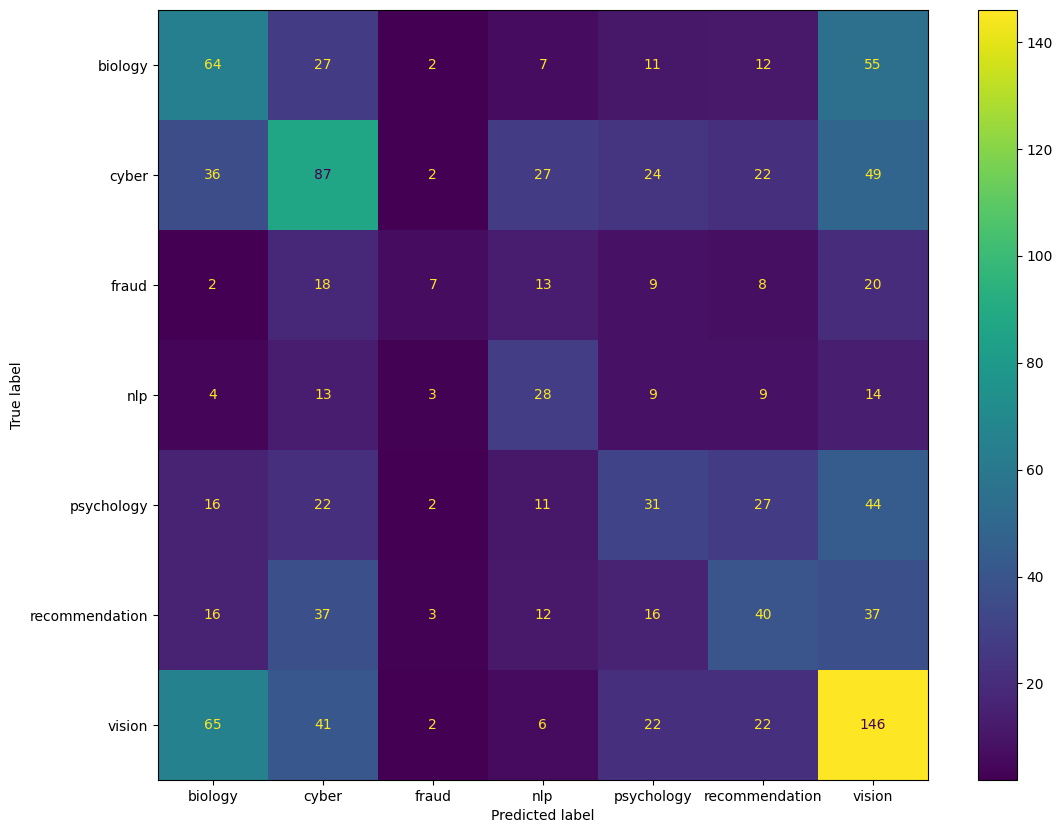

In [107]:
class_mapping = {
    1: 'cyber',
    6: 'vision',
    0: 'biology',
    4: 'psychology',
    5: 'recommendation',
    2: 'fraud',
    3: 'nlp'
}

cm = confusion_matrix(y_topic_test, y_topic_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[class_mapping[i] for i in range(len(class_mapping))])
fig, ax = plt.subplots(figsize=(13, 10))
ax.grid(False)
disp.plot(ax=ax)
plt.show()

As we can see, the results are very low, indicating a lack of distinctive features among the images across various topics.

But since we saw in the exploratory analysis that the number of figures is very different across the topics, we will try to do the prediction using the top 3 topics (with the highest number of figures). The topics are: vision, cyber and biology.

In [118]:
short_topic_df = features_df

short_topic_df = pd.get_dummies(features_df, columns=['gender'], drop_first=False)

label_encoder = LabelEncoder()
years = short_topic_df['year']
ordinal_years = label_encoder.fit_transform(years)
short_topic_df['ordinal_year'] = ordinal_years
# topic_df['class'] = label_encoder.fit_transform(topic_df['topic'])
short_topic_df = short_topic_df.drop(['year'], axis=1)

topics_to_keep = ['vision', 'cyber', 'biology']

# Filter the DataFrame to keep only rows with the specified topics
filtered_df = short_topic_df.loc[short_topic_df['topic'].isin(topics_to_keep)]

filtered_df

,topic,feature 0,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6,feature 7,feature 8,...,feature 993,feature 994,feature 995,feature 996,feature 997,feature 998,feature 999,gender_female,gender_male,ordinal_year
0,cyber,-2.972674,-3.047310,-2.126097,-3.527888,-2.712270,-1.683633,-4.031274,-1.427207,-1.740036,...,-2.179673,-4.551397,-2.014676,-0.368375,-5.364916,0.572040,2.298274,1,0,6
1,vision,-1.644412,-1.086765,-1.011632,-2.495976,-0.846086,-0.623605,-2.315911,-2.251968,-2.357715,...,-1.756415,-2.858241,-0.795387,0.370200,-3.360076,0.554196,3.837938,1,0,10
2,biology,-1.534068,-0.935432,-0.422487,-2.035745,-0.808009,-0.114899,-1.942848,-1.927812,-1.787214,...,-1.746720,-2.846321,-2.697180,-1.034146,-3.567086,0.926263,4.189312,0,1,3
3,cyber,-3.320873,0.231886,-3.766049,-3.075788,-1.044822,0.564748,-1.261342,-2.391707,-2.024328,...,-0.889132,-2.322804,1.105262,1.241995,-3.001455,-1.033573,2.062096,0,1,8
5,cyber,-2.906192,-2.012823,-2.367835,-1.757696,-1.081452,0.486351,-0.721313,-1.692066,-2.328854,...,-1.154753,-3.140958,-1.174568,0.120654,-3.193092,-0.682664,4.412315,0,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5993,vision,-0.702532,-1.719659,-1.667192,-3.586624,-2.599473,1.200523,-3.460068,-0.730065,-1.048067,...,-1.428694,-3.069604,-1.730430,-0.870093,-3.940294,-0.281282,1.375295,0,1,9
5995,cyber,-3.777776,-2.853549,-3.329462,-0.437348,-0.110610,3.165693,-0.185102,-3.745954,-4.587151,...,-1.213215,-1.827963,-0.535734,-0.811988,-1.872801,0.189452,8.302977,0,1,7
5996,vision,-3.036834,-1.759813,-0.770050,-0.488117,1.264974,1.337877,-1.217332,-0.069135,-1.102958,...,-1.388870,-3.831133,0.500158,1.137484,-4.370120,-2.392373,1.711594,0,1,7
5997,cyber,-1.855752,-1.559144,-2.684390,-3.335156,-0.344629,1.209395,-4.198448,-2.256841,-2.328968,...,-0.287263,-3.033630,-0.570579,0.526134,-3.444198,1.089184,1.060454,0,1,10


In [119]:
filtered_df['class'] = label_encoder.fit_transform(filtered_df['topic'])

# Get the mapping of encoded values to original class labels
class_mapping = {encoded_value: original_label for original_label, encoded_value in zip(filtered_df['topic'], label_encoder.transform(filtered_df['topic']))}
filtered_df = filtered_df.drop(['topic'], axis=1)

print(class_mapping)
filtered_df

{1: 'cyber', 2: 'vision', 0: 'biology'}



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,feature 0,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6,feature 7,feature 8,feature 9,...,feature 994,feature 995,feature 996,feature 997,feature 998,feature 999,gender_female,gender_male,ordinal_year,class
0,-2.972674,-3.047310,-2.126097,-3.527888,-2.712270,-1.683633,-4.031274,-1.427207,-1.740036,-1.935419,...,-4.551397,-2.014676,-0.368375,-5.364916,0.572040,2.298274,1,0,6,1
1,-1.644412,-1.086765,-1.011632,-2.495976,-0.846086,-0.623605,-2.315911,-2.251968,-2.357715,-4.197502,...,-2.858241,-0.795387,0.370200,-3.360076,0.554196,3.837938,1,0,10,2
2,-1.534068,-0.935432,-0.422487,-2.035745,-0.808009,-0.114899,-1.942848,-1.927812,-1.787214,-2.613806,...,-2.846321,-2.697180,-1.034146,-3.567086,0.926263,4.189312,0,1,3,0
3,-3.320873,0.231886,-3.766049,-3.075788,-1.044822,0.564748,-1.261342,-2.391707,-2.024328,-2.155904,...,-2.322804,1.105262,1.241995,-3.001455,-1.033573,2.062096,0,1,8,1
5,-2.906192,-2.012823,-2.367835,-1.757696,-1.081452,0.486351,-0.721313,-1.692066,-2.328854,-2.974362,...,-3.140958,-1.174568,0.120654,-3.193092,-0.682664,4.412315,0,1,9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5993,-0.702532,-1.719659,-1.667192,-3.586624,-2.599473,1.200523,-3.460068,-0.730065,-1.048067,-1.459604,...,-3.069604,-1.730430,-0.870093,-3.940294,-0.281282,1.375295,0,1,9,2
5995,-3.777776,-2.853549,-3.329462,-0.437348,-0.110610,3.165693,-0.185102,-3.745954,-4.587151,-4.787772,...,-1.827963,-0.535734,-0.811988,-1.872801,0.189452,8.302977,0,1,7,1
5996,-3.036834,-1.759813,-0.770050,-0.488117,1.264974,1.337877,-1.217332,-0.069135,-1.102958,-2.298857,...,-3.831133,0.500158,1.137484,-4.370120,-2.392373,1.711594,0,1,7,2
5997,-1.855752,-1.559144,-2.684390,-3.335156,-0.344629,1.209395,-4.198448,-2.256841,-2.328968,-1.738955,...,-3.033630,-0.570579,0.526134,-3.444198,1.089184,1.060454,0,1,10,1


In [120]:
X_filter_topic = filtered_df.drop(columns=['class'])
y_filter_topic = filtered_df['class']

# Split the data into training and testing sets
X_filter_topic_train, X_filter_topic_test, y_filter_topic_train, y_filter_topic_test = train_test_split(X_filter_topic, y_filter_topic, test_size=0.2, random_state=42)

filter_topic_model = CatBoostClassifier(iterations=3000, random_seed=42,
                          learning_rate=0.1,
                          depth=4)
filter_topic_model.fit(X_filter_topic_train, y_filter_topic_train)

0:	learn: 1.0868722	total: 464ms	remaining: 23m 12s
1:	learn: 1.0774372	total: 666ms	remaining: 16m 38s
2:	learn: 1.0713865	total: 866ms	remaining: 14m 25s
3:	learn: 1.0626645	total: 1.08s	remaining: 13m 29s
4:	learn: 1.0563551	total: 1.28s	remaining: 12m 45s
5:	learn: 1.0500657	total: 1.48s	remaining: 12m 20s
6:	learn: 1.0454563	total: 1.7s	remaining: 12m 8s
7:	learn: 1.0402507	total: 1.93s	remaining: 12m 2s
8:	learn: 1.0333269	total: 2.17s	remaining: 12m
9:	learn: 1.0278704	total: 2.4s	remaining: 11m 58s
10:	learn: 1.0237018	total: 2.63s	remaining: 11m 53s
11:	learn: 1.0208474	total: 2.82s	remaining: 11m 42s
12:	learn: 1.0162093	total: 3.02s	remaining: 11m 33s
13:	learn: 1.0125116	total: 3.21s	remaining: 11m 24s
14:	learn: 1.0101821	total: 3.42s	remaining: 11m 19s
15:	learn: 1.0067794	total: 3.62s	remaining: 11m 15s
16:	learn: 1.0035919	total: 3.95s	remaining: 11m 32s
17:	learn: 1.0013717	total: 4.61s	remaining: 12m 43s
18:	learn: 0.9989399	total: 5.71s	remaining: 14m 55s
19:	learn: 

In [121]:
y_filter_topic_predict = filter_topic_model.predict(X_filter_topic_test)

accuracy = accuracy_score(y_filter_topic_test,y_filter_topic_predict)
precision_micro = precision_score(y_filter_topic_test, y_filter_topic_predict, average='micro')
recall_micro = recall_score(y_filter_topic_test, y_filter_topic_predict, average='micro')
f1_micro = f1_score(y_filter_topic_test, y_filter_topic_predict, average='micro')
print("Accuracy:" , accuracy)
print("Precision:", precision_micro)
print("Recall:", recall_micro)
print("F1-Score:", f1_micro)

Accuracy: 0.5446927374301676
Precision: 0.5446927374301676
Recall: 0.5446927374301676
F1-Score: 0.5446927374301676


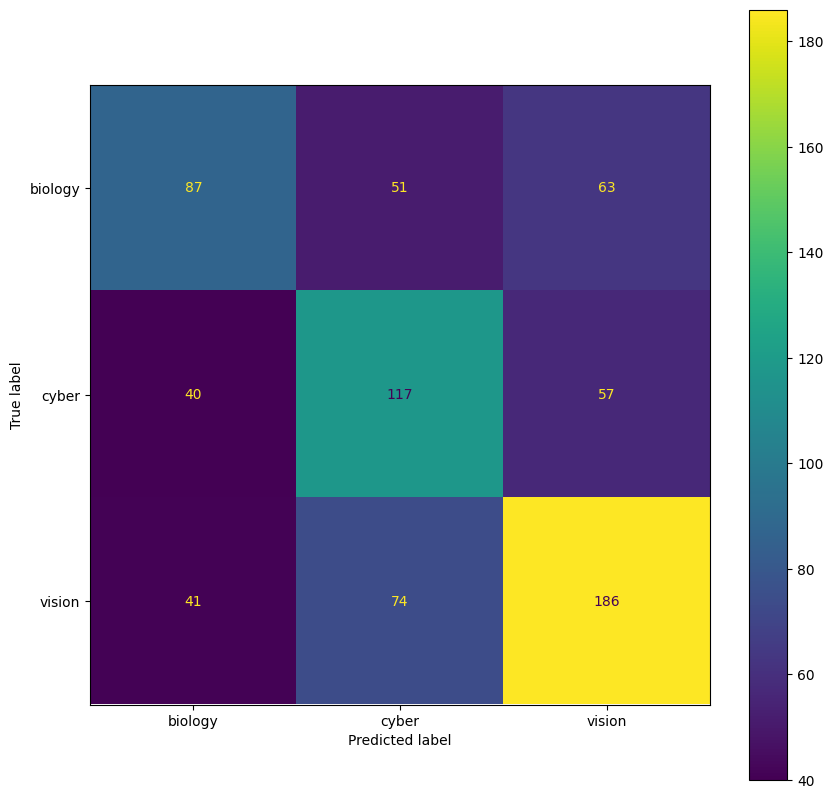

In [124]:
class_filter_mapping = {
    1: 'cyber',
    2: 'vision',
    0: 'biology',
}

cm = confusion_matrix(y_filter_topic_test, y_filter_topic_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[class_filter_mapping[i] for i in range(len(class_filter_mapping))])
fig, ax = plt.subplots(figsize=(10, 10))
ax.grid(False)
disp.plot(ax=ax)
plt.show()

We were able to improve the prediction, but it is still low. Further exploration is required to potentially enhance the prediction accuracy. However, considering the utilization of only vector images and a limited set of unrelated features, we hold the belief that substantial improvement in prediction may not be achievable. Our conjecture is that there might not be specific types of figures with distinctive characteristics that are consistently unique to particular topics.

# Image Similarity Graph

calculating similarity measure between images

<ipython-input-3-884e76f2c67b>:25: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(url)


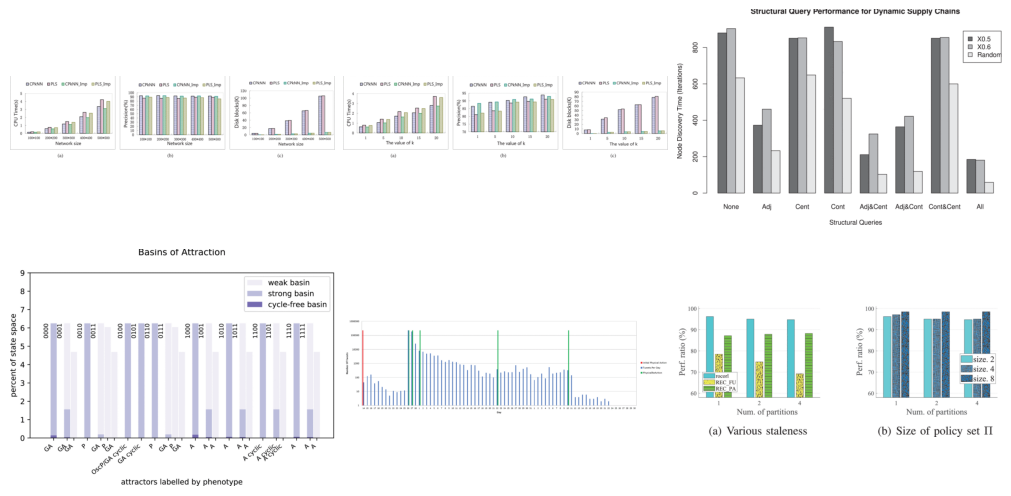

In [ ]:
def find_most_similar_vectors(query_vector, vectors_dict, kdtree, k=6):

    # Perform a nearest neighbor search for the query vector
    _, indices = kdtree.query(np.array(query_vector).reshape(1, -1), k=k)

    # Get the keys of the most similar vectors
    top_keys = [list(vectors_dict.keys())[idx] for idx in indices.flatten()]

    return top_keys

# dict from image to embedding
vectors_dict = full_df.set_index('figure_link')['image_vector'].to_dict()

# Build a KDTree using the vectors
kdtree = KDTree(list(vectors_dict.values()))

v = vectors_dict['https://ieeexplore.ieee.org/mediastore_new/IEEE/content/media/6287639/7419931/7769182/zhu10abc-2635682-large.gif']
image_urls = find_most_similar_vectors(v, vectors_dict, kdtree, k=6)


_, axs = plt.subplots(2, 3, figsize=(10, 5),constrained_layout = True)
axs = axs.flatten()
for url, ax in zip(image_urls, axs):
    ax.axis('off')
    image = imageio.imread(url)
    ax.imshow(image)
plt.show()

creating graph, similar vectors are connected

In [ ]:
start_image = 'https://ieeexplore.ieee.org/mediastore_new/IEEE/content/media/6287639/7419931/7769182/zhu10abc-2635682-large.gif'
images_list = [start_image]
images_links = []
visited_images = set()

while len(images_list) > 0 and len(visited_images) < 15:
  i = images_list.pop()
  visited_images.add(i)
  v = vectors_dict[i]
  similar_images = find_most_similar_vectors(v, vectors_dict, kdtree)

  for i2 in similar_images:
    images_links.append((i,i2))
    if i2 not in visited_images:
      images_list.append(i2)

g = nx.DiGraph()
for u,v in images_links:
  g.add_edge(u,v)

print(g)

DiGraph with 58 nodes and 90 edges


<ipython-input-6-b72ab3a177f5>:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(node)


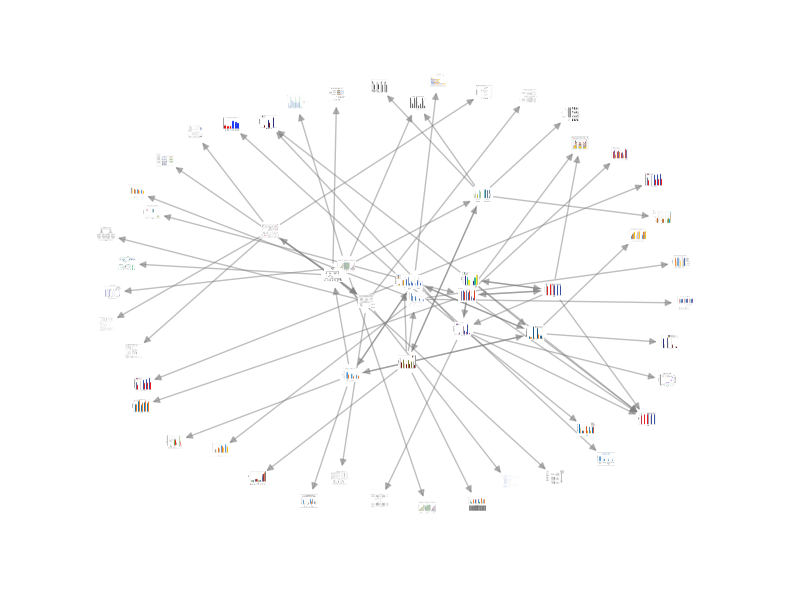

In [ ]:
# draw network

def draw_graph(graph):
    pos = nx.spring_layout(graph)  # Layout algorithm

    # Create a new figure
    fig, ax = plt.subplots(figsize=(8, 6))

    # Iterate through nodes and add images
    for node, (x, y) in pos.items():
        #image_url = node  # ['image']
        image = imageio.imread(node)
   #     image = image.resize((30, 30))  # Resize the image
        ax.imshow(image, extent=(x - 0.03, x + 0.03, y - 0.03, y + 0.03), aspect='auto', zorder=2)

    # Draw the edges
    nx.draw_networkx_edges(graph, pos, ax=ax, alpha=0.5, edge_color='gray')

    plt.axis('off')
    axis = plt.gca()
    axis.set_xlim([1.1*x for x in axis.get_xlim()])
    axis.set_ylim([1.1*y for y in axis.get_ylim()])
    plt.tight_layout()
    plt.show()

# Draw the graph with images as nodes
g.remove_edges_from(nx.selfloop_edges(g))
draw_graph(g)
